# Proyecto de Clasificación de etapas de sueño en PSG

**Tutor:** Rodrigo Catalán  
**EL4106-1 - Primavera 2025**  
**Integrantes:** Pablo Rivera y Mauricio Silva


## Importacion de database

In [ ]:
%pip install mne wget
!pip install antropy

In [ ]:
import os
import mne
import wget
import zipfile
from google.colab import drive

#se monta archivo de colab
drive.mount("/content/drive", force_remount=True)
datapath = "/content/drive/MyDrive/sleep-edf-database-expanded-1.0.0/sleep-cassette/"

Mounted at /content/drive


In [ ]:
#N de individuos
files = sorted(os.listdir(datapath))
n_sujetos = len(files)/2
print(n_sujetos)

153.0


## Visualizacion de los datos

In [ ]:
ex_psg = datapath + "SC4001E0-PSG.edf" #archivo de PSG
ex_hipnograma = datapath + "SC4001EC-Hypnogram.edf" #archivo de hipnograma (con anotaciones -> labels)

#se cargan los archivos y se extrae su data
raw = mne.io.read_raw_edf(ex_psg, preload=True)
annotations = mne.read_annotations(ex_hipnograma)
raw.set_annotations(annotations)

Extracting EDF parameters from /content/drive/MyDrive/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/tmp/ipython-input-1887714984.py:5: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(ex_psg, preload=True)
/tmp/ipython-input-1887714984.py:5: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(ex_psg, preload=True)
/tmp/ipython-input-1887714984.py:5: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(ex_psg, preload=True)


Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...


/tmp/ipython-input-1887714984.py:7: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)


<RawEDF | SC4001E0-PSG.edf, 7 x 7950000 (79500.0 s), ~424.6 MiB, data loaded>

In [ ]:
#se separa la data importante para legibilidad
print("Canales disponibles:", raw.ch_names)
print("Duración (seg):", raw.times[-1])

Canales disponibles: ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker']
Duración (seg): 79499.99


In [ ]:
#se extrae data de las annotations (notar que duration viene en multiplos de 30 seg)
i=0
for a in annotations[13:45]: #algunos ejemplos
    print(i, a)
    i+=1

0 OrderedDict({'onset': np.float64(31800.0), 'duration': np.float64(30.0), 'description': np.str_('Sleep stage W'), 'orig_time': None, 'extras': {}})
1 OrderedDict({'onset': np.float64(31830.0), 'duration': np.float64(60.0), 'description': np.str_('Sleep stage 3'), 'orig_time': None, 'extras': {}})
2 OrderedDict({'onset': np.float64(31890.0), 'duration': np.float64(60.0), 'description': np.str_('Sleep stage 2'), 'orig_time': None, 'extras': {}})
3 OrderedDict({'onset': np.float64(31950.0), 'duration': np.float64(120.0), 'description': np.str_('Sleep stage 3'), 'orig_time': None, 'extras': {}})
4 OrderedDict({'onset': np.float64(32070.0), 'duration': np.float64(30.0), 'description': np.str_('Sleep stage 4'), 'orig_time': None, 'extras': {}})
5 OrderedDict({'onset': np.float64(32100.0), 'duration': np.float64(30.0), 'description': np.str_('Sleep stage 3'), 'orig_time': None, 'extras': {}})
6 OrderedDict({'onset': np.float64(32130.0), 'duration': np.float64(120.0), 'description': np.str_(

<Figure size 800x400 with 0 Axes>

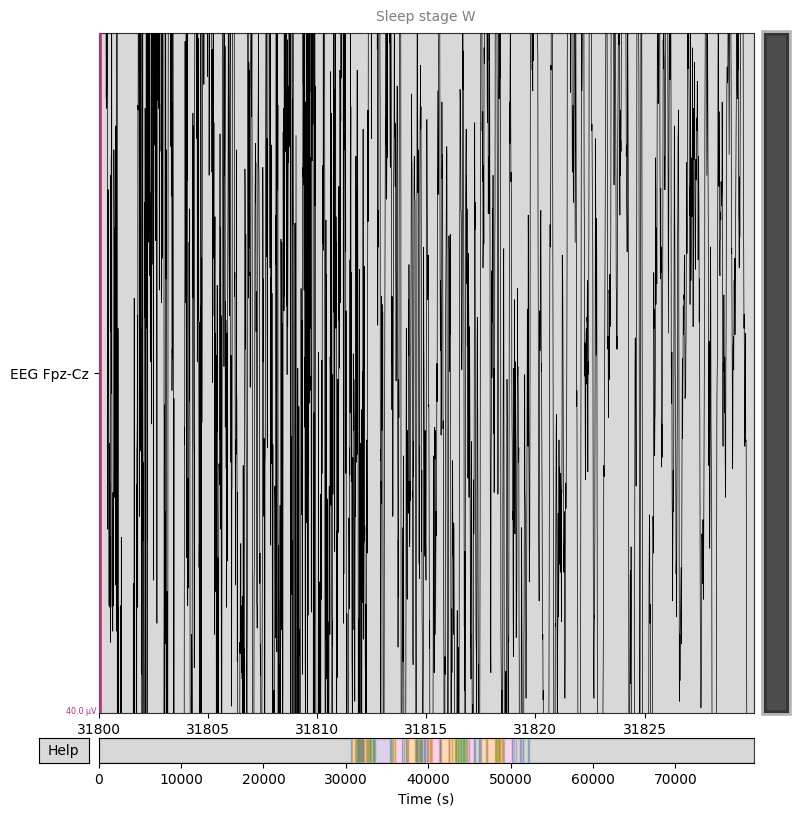

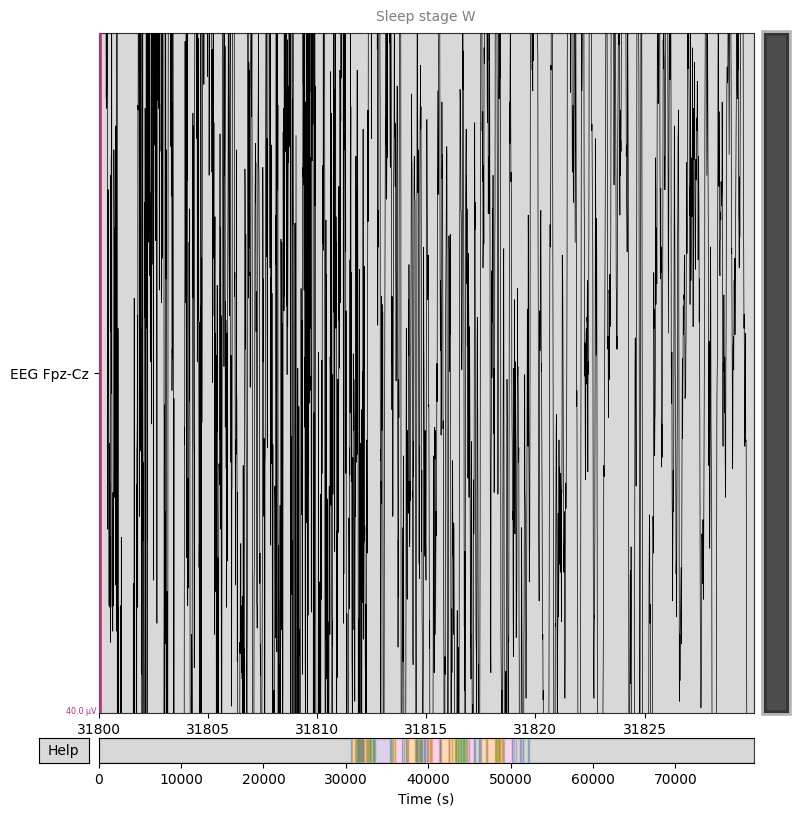

In [ ]:
#grafico de data cruda

raw.pick("EEG Fpz-Cz").plot(start=31800, duration=30)

##

# Machine Learning

## Separar datos de hipnograma

In [ ]:
#librerias
import os, re
import numpy as np
import pandas as pd
import mne
from pathlib import Path
import zipfile
from google.colab import drive
from scipy.signal import welch
from scipy.stats import kurtosis, entropy, skew #por si se necesitan mas features
import antropy as ant
from tqdm import tqdm

In [ ]:
#se monta archivo de colab
drive.mount("/content/drive", force_remount=True)

#se asigna direcciones de los datos
datapath = "/content/drive/MyDrive/sleep-edf-database-expanded-1.0.0/sleep-cassette/"
# Se crea la carpeta de salida en Google Drive si no existe
out_folder = "/content/drive/MyDrive/sleep-edf-processed/"
Path(out_folder).mkdir(exist_ok=True, parents=True)
from pathlib import Path
Path(out_folder).mkdir(exist_ok=True, parents=True) #direccion de datos procesados

#se buscan los archivos de hipnograma
files = sorted(os.listdir(datapath))
hypno_files = [os.path.join(datapath,f) for f in files if "Hypnogram" in f]
print(f"Encontrados {len(hypno_files)} hipnogramas (ej: {hypno_files[-1]})")

Mounted at /content/drive
Encontrados 153 hipnogramas (ej: /content/drive/MyDrive/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4822GC-Hypnogram.edf)


In [ ]:
files = sorted(os.listdir(datapath))
psg_files = [f for f in files if f.endswith("PSG.edf")]

sujetos_list = sorted(list(set(re.findall(r"(SC\d+)", " ".join(psg_files)))))
print(sujetos_list)
print(len(sujetos_list))
print(psg_files)
print(len(psg_files))

['SC4001', 'SC4002', 'SC4011', 'SC4012', 'SC4021', 'SC4022', 'SC4031', 'SC4032', 'SC4041', 'SC4042', 'SC4051', 'SC4052', 'SC4061', 'SC4062', 'SC4071', 'SC4072', 'SC4081', 'SC4082', 'SC4091', 'SC4092', 'SC4101', 'SC4102', 'SC4111', 'SC4112', 'SC4121', 'SC4122', 'SC4131', 'SC4141', 'SC4142', 'SC4151', 'SC4152', 'SC4161', 'SC4162', 'SC4171', 'SC4172', 'SC4181', 'SC4182', 'SC4191', 'SC4192', 'SC4201', 'SC4202', 'SC4211', 'SC4212', 'SC4221', 'SC4222', 'SC4231', 'SC4232', 'SC4241', 'SC4242', 'SC4251', 'SC4252', 'SC4261', 'SC4262', 'SC4271', 'SC4272', 'SC4281', 'SC4282', 'SC4291', 'SC4292', 'SC4301', 'SC4302', 'SC4311', 'SC4312', 'SC4321', 'SC4322', 'SC4331', 'SC4332', 'SC4341', 'SC4342', 'SC4351', 'SC4352', 'SC4362', 'SC4371', 'SC4372', 'SC4381', 'SC4382', 'SC4401', 'SC4402', 'SC4411', 'SC4412', 'SC4421', 'SC4422', 'SC4431', 'SC4432', 'SC4441', 'SC4442', 'SC4451', 'SC4452', 'SC4461', 'SC4462', 'SC4471', 'SC4472', 'SC4481', 'SC4482', 'SC4491', 'SC4492', 'SC4501', 'SC4502', 'SC4511', 'SC4512',

In [ ]:
"""
df_all = pd.read_csv("/content/drive/MyDrive/all_subjects_features_multichannel.csv")
display(df_all.head())
"""

'\ndf_all = pd.read_csv("/content/drive/MyDrive/all_subjects_features_multichannel.csv")\ndisplay(df_all.head())\n'

#### Graficos relevantes de data

In [ ]:
#caso 7 features
df_all = pd.read_csv(out_folder + "all_subjects_features.csv").dropna()
df_unique = df_all.drop_duplicates(subset=["stage"])
display(df_unique)

,sujeto,epoch_index,stage,code,EEG_delta,EEG_theta,EEG_alpha,EEG_sigma,EEG_beta,EEG_mean,EEG_std
0,SC4001,0,W,0,0.668023,0.063817,0.006059,0.003160,0.007866,4.087560e-07,0.000036
1021,SC4001,1021,N1,1,0.548778,0.268089,0.061326,0.027450,0.031057,2.302437e-07,0.000009
1025,SC4001,1025,N2,2,0.830733,0.090083,0.010388,0.006202,0.009001,2.600322e-07,0.000017
1038,SC4001,1038,N3,3,0.795718,0.081187,0.013053,0.017627,0.003875,2.109890e-07,0.000024
1199,SC4001,1199,REM,4,0.563847,0.229600,0.012379,0.007958,0.007141,4.963712e-08,0.000015


[]

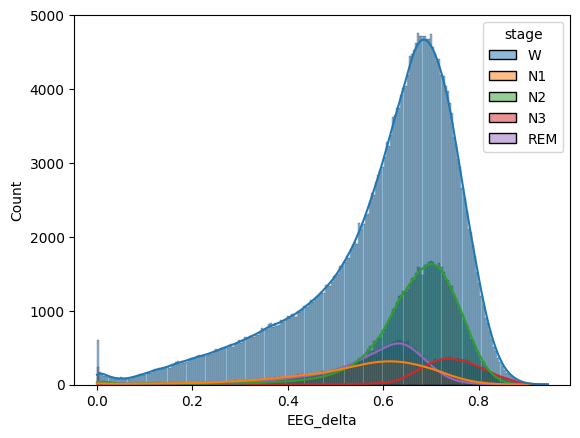

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=df_all, x="EEG_delta", hue="stage", kde=True)
plt.plot()

[]

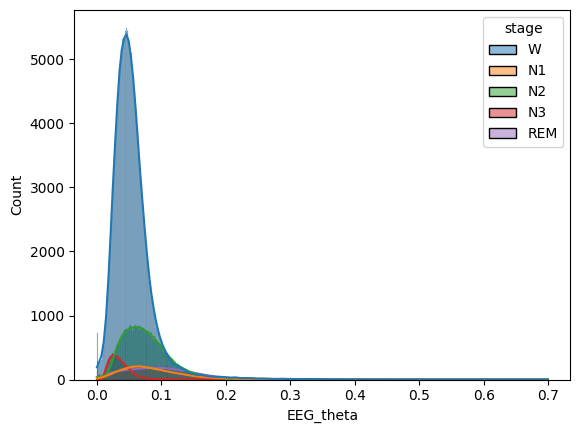

In [ ]:
sns.histplot(data=df_all, x="EEG_theta", hue="stage", kde=True)
plt.plot()

[]

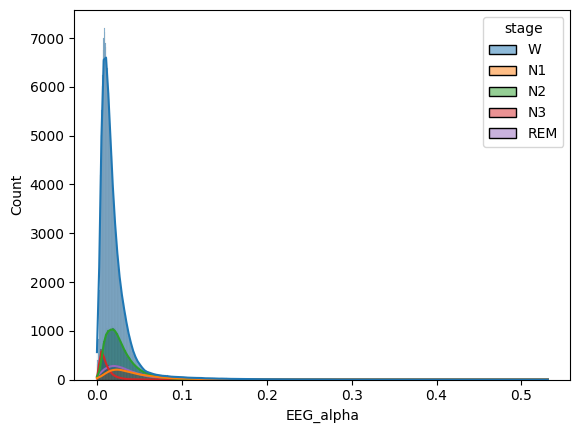

In [ ]:
sns.histplot(data=df_all, x="EEG_alpha", hue="stage", kde=True)
plt.plot()

[]

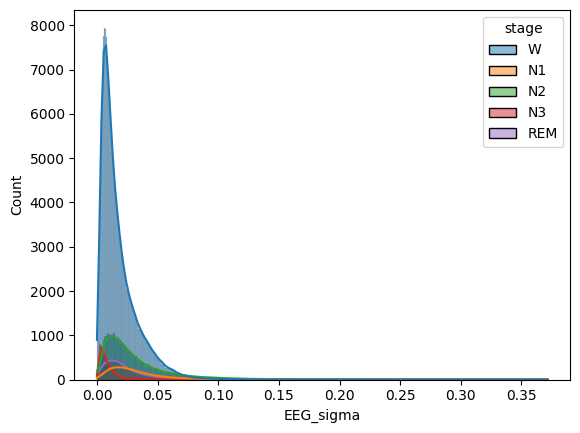

In [ ]:
sns.histplot(data=df_all, x="EEG_sigma", hue="stage", kde=True)
plt.plot()

[]

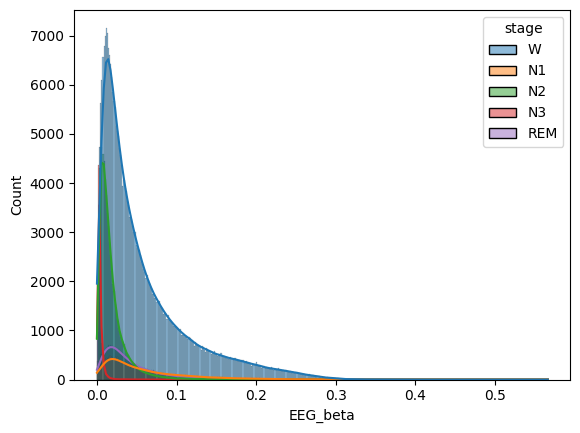

In [ ]:
sns.histplot(data=df_all, x="EEG_beta", hue="stage", kde=True)
plt.plot()

[]

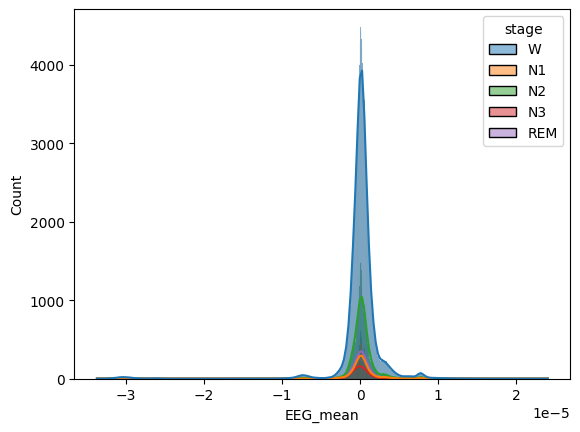

In [ ]:
sns.histplot(data=df_all, x="EEG_mean", hue="stage", kde=True)
plt.plot()

[]

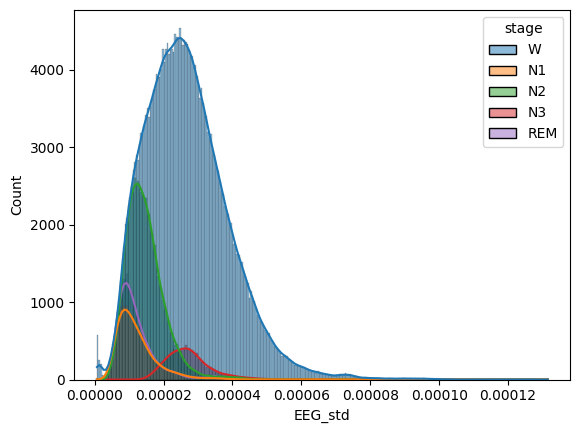

In [ ]:
sns.histplot(data=df_all, x="EEG_std", hue="stage", kde=True)
plt.plot()

# MLP

##Data balance

In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import time

# Cargar dataset
out_folder = "/content/drive/MyDrive/sleep-edf-processed/"
df_all = pd.read_csv(out_folder + "all_subjects_features.csv").dropna()

# Columnas de features
cols_excluir = ["sujeto", "epoch_index", "stage", "code"]
feature_cols = [c for c in df_all.columns if c not in cols_excluir]

# Separación por sujeto (60% train, 20% val, 20% test)
unique_subjects = np.unique(df_all["sujeto"])
train_subjects, temp_subjects = train_test_split(unique_subjects, test_size=0.4, random_state=42)
val_subjects, test_subjects = train_test_split(temp_subjects, test_size=0.5, random_state=42)

# Función para filtrar por sujeto
def sujeto_in_conjunto(df, sujetos_list):
    return df[df["sujeto"].isin(sujetos_list)]

# Dataframes desbalanceados
df_train = sujeto_in_conjunto(df_all, train_subjects)
df_val = sujeto_in_conjunto(df_all, val_subjects)
df_test = sujeto_in_conjunto(df_all, test_subjects)  # No se balancea

print("# DataFrame desbalanceado (df_train)")
display(df_train.head())
print(df_train["stage"].value_counts())

print("# DataFrame desbalanceado (df_val)")
print(df_val["stage"].value_counts())

print("# DataFrame desbalanceado (df_test)")
print(df_test["stage"].value_counts())

############################################################
# IMPORTANTE
# En esta sección se aplica una estrategia combinada de:
# - UNDERSAMPLING para la clase mayoritaria (W)
# - OVERSAMPLING para las clases minoritarias (REM, N1, N3)
#
# Esta combinación se utiliza cuando hay una diferencia
# muy grande entre las cantidades de datos por clase,
# como en este caso donde W tiene más de 160 mil muestras
# y N3 apenas supera las 7 mil.
#
# ¿Por qué?
# - El undersampling reduce el dominio excesivo de la clase
#   mayoritaria, evitando que el modelo se sesgue hacia ella.
# - El oversampling refuerza las clases minoritarias para que
#   el modelo pueda aprender patrones representativos de ellas.
# - Al no igualar completamente todas las clases, se evita
#   tanto la pérdida de información (por undersampling agresivo)
#   como el riesgo de overfitting (por oversampling excesivo).
# - Al testear con balanceo de undersampling puro
#   me daba (966 batches vs 141 batches)
#
# Esta estrategia permite un balance más realista y efectivo
# para el entrenamiento, manteniendo diversidad de datos y
# mejorando la capacidad del modelo para generalizar.
############################################################

# --- Función para balancear por clase ---
def balanceo_df(df, objetivos, clase_col='code', rng_seed=42):
    grupos = df.groupby(clase_col)
    dfs_balanceados = []

    for clase, group in grupos:
        n_objetivo = objetivos.get(clase, len(group))
        if len(group) > n_objetivo:
            # Submuestreo
            sampleado = group.sample(n=n_objetivo, random_state=rng_seed)
        elif len(group) < n_objetivo:
            # Sobremuestreo con reemplazo
            sampleado = group.sample(n=n_objetivo, replace=True, random_state=rng_seed)
        else:
            sampleado = group
        dfs_balanceados.append(sampleado)

    df_final = pd.concat(dfs_balanceados).sample(frac=1, random_state=rng_seed).reset_index(drop=True)
    return df_final

# --- Objetivos de balanceo ---
objetivos_train = {
    0: 50000,   # W
    1: 41740,   # N2
    2: 30000,   # REM
    3: 30000,   # N1
    4: 15000    # N3
}

objetivos_val = {
    0: 25000,   # W
    1: 13306,   # N2
    2: 9000,    # REM
    3: 9000,    # N1
    4: 5000     # N3
}

# --- Aplicar balanceo ---
df_train_balanceado = balanceo_df(df_train, objetivos=objetivos_train)
#df_val_balanceado = balanceo_df(df_val, objetivos=objetivos_val)

print("# DataFrame balanceado (df_train_balanceado)")
display(df_train_balanceado.head())
print(df_train_balanceado["stage"].value_counts())

#print("# DataFrame balanceado (df_val_balanceado)")
#print(df_val_balanceado["stage"].value_counts())

#print("# DataFrame de test (df_test) (se hace desbalanceado segun el aux)")
#print(df_test["stage"].value_counts())

# Normalización y tensores - conjunto test (desbalanceado por default)

scaler_test = StandardScaler()
X_test_np = df_test[feature_cols].values.astype(np.float32)
X_test_scaled = scaler_test.fit_transform(X_test_np)
X_test = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test = torch.tensor(df_test["code"].values, dtype=torch.long)

test_dataset = TensorDataset(X_test, y_test)

# Normalización y tensores - desbalanceado
scaler_desb = StandardScaler()
X_train_desb = scaler_desb.fit_transform(df_train[feature_cols].values.astype(np.float32))
X_val_desb = scaler_desb.transform(df_val[feature_cols].values.astype(np.float32))

X_train_desbalanceado = torch.tensor(X_train_desb, dtype=torch.float32)
y_train_desbalanceado = torch.tensor(df_train["code"].values, dtype=torch.long)
X_val_desbalanceado = torch.tensor(X_val_desb, dtype=torch.float32)
y_val_desbalanceado = torch.tensor(df_val["code"].values, dtype=torch.long)

train_dataset = TensorDataset(X_train_desbalanceado, y_train_desbalanceado)
val_dataset = TensorDataset(X_val_desbalanceado, y_val_desbalanceado)

# Normalización y tensores - balanceado
scaler_bal = StandardScaler()
X_train_bal = scaler_bal.fit_transform(df_train_balanceado[feature_cols].values.astype(np.float32))
#X_val_bal = scaler_bal.transform(df_val_balanceado[feature_cols].values.astype(np.float32))

X_train_balanceado = torch.tensor(X_train_bal, dtype=torch.float32)
y_train_balanceado = torch.tensor(df_train_balanceado["code"].values, dtype=torch.long)

#se quitan los val balanceados
#X_val_balanceado = torch.tensor(X_val_bal, dtype=torch.float32)
#y_val_balanceado = torch.tensor(df_val_balanceado["code"].values, dtype=torch.long)

train_dataset_balanceado = TensorDataset(X_train_balanceado, y_train_balanceado)
val_dataset = TensorDataset(X_val_desbalanceado, y_val_desbalanceado)

# DataFrame desbalanceado (df_train)


,sujeto,epoch_index,stage,code,EEG_delta,EEG_theta,EEG_alpha,EEG_sigma,EEG_beta,EEG_mean,EEG_std
2650,SC4002,0,W,0,0.620759,0.067534,0.013880,0.010385,0.036272,2.490193e-07,0.000031
2651,SC4002,1,W,0,0.622300,0.032508,0.009057,0.005327,0.017695,9.313243e-07,0.000043
2652,SC4002,2,W,0,0.643456,0.123804,0.022489,0.008139,0.017262,2.115285e-06,0.000035
2653,SC4002,3,W,0,0.614611,0.053247,0.009927,0.009639,0.028970,-8.789683e-07,0.000049
2654,SC4002,4,W,0,0.689498,0.074490,0.013024,0.009631,0.034269,9.025399e-07,0.000038


stage
W      169377
N2      41740
REM     15464
N1      13308
N3       7182
Name: count, dtype: int64
# DataFrame desbalanceado (df_val)
stage
W      58426
N2     13306
REM     4713
N1      4539
N3      2889
Name: count, dtype: int64
# DataFrame desbalanceado (df_test)
stage
W      57630
N2     14086
REM     5658
N1      3675
N3      2968
Name: count, dtype: int64
# DataFrame balanceado (df_train_balanceado)


,sujeto,epoch_index,stage,code,EEG_delta,EEG_theta,EEG_alpha,EEG_sigma,EEG_beta,EEG_mean,EEG_std
0,SC4651,1037,N3,3,0.703873,0.032735,0.009703,0.004264,0.001628,1.393903e-06,0.000019
1,SC4561,2304,W,0,0.636138,0.069537,0.018754,0.010828,0.030701,-4.164376e-07,0.000032
2,SC4462,2186,W,0,0.582781,0.049278,0.024463,0.023046,0.087192,7.493484e-06,0.000027
3,SC4321,916,W,0,0.732409,0.033555,0.007751,0.006704,0.011949,1.994953e-07,0.000018
4,SC4271,1112,N3,3,0.736891,0.025707,0.017573,0.005677,0.002305,2.398958e-08,0.000040


stage
W      50000
N1     41740
N3     30000
N2     30000
REM    15000
Name: count, dtype: int64


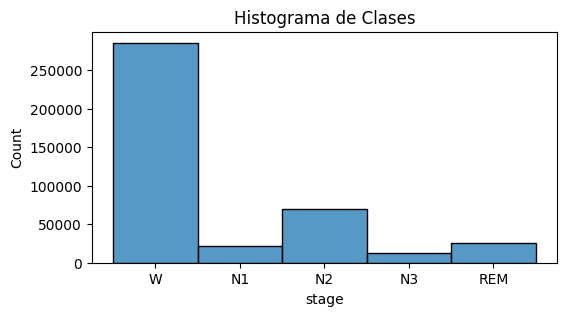

In [ ]:
import seaborn as sns
plt.figure(figsize=(6,3))
sns.histplot(df_all["stage"])
plt.title("Histograma de Clases")
plt.show()

In [ ]:
######################
##### MLP Simple #####
######################

import torch.nn as nn

class SimpleMLPModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(7, 32),
            nn.ReLU(),
            nn.Linear(32, 5)
        )

    def forward(self, x):
        return self.net(x)

########################
##### MLP Mejorado #####
########################

class MLPModel(nn.Module):
    def __init__(self, dropout_p):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(7, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout_p),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout_p),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.Linear(64, 5)
        )

    def forward(self, x):
        return self.net(x)

class EarlyStopping:
    def __init__(self, n_epochs_tolerance):
        self.n_epochs_tolerance = n_epochs_tolerance
        self.epochs_with_no_improvement = 0
        self.best_loss = np.inf

    def __call__(self, val_loss):
        # En cada llamada aumentamos el número de épocas en que no hemos mejorado
        self.epochs_with_no_improvement += 1

        if val_loss <= self.best_loss:
            # Si efectivamente mejoramos (menor loss de validación) reiniciamos el número de épocas sin mejora
            self.best_loss = val_loss
            self.epochs_with_no_improvement = 0

        # Retornamos True si debemos detenernos y False si aún no
        # Nos detenemos cuando el número de épocas sin mejora es mayor o igual que el número de épocas de tolerancia
        return self.epochs_with_no_improvement >= self.n_epochs_tolerance

In [ ]:
def train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu):
    # Predicción
    y_predicted = model(x_batch)

    # Cálculo de loss
    loss = criterion(y_predicted, y_batch)

    # Actualización de parámetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return y_predicted, loss

def train_model(
    model,
    train_dataset,
    val_dataset,
    max_epochs,
    criterion,
    batch_size,
    lr,
    n_evaluations_per_epoch=6,
    early_stopping_tolerance=25, #cambiar si hay mucho early stopping
    use_gpu=False
):
    if use_gpu:
        model.cuda()

    early_stopping = EarlyStopping(n_epochs_tolerance=early_stopping_tolerance)

    # Definición de dataloader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=use_gpu)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False, pin_memory=use_gpu)

    # Optimizador
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Listas para guardar curvas de entrenamiento
    curves = {
        "train_acc": [],
        "val_acc": [],
        "train_loss": [],
        "val_loss": [],
        "train_cm": [] # Para guardar matriz de confusion por epoca
    }

    # Early stopping
    n_epochs_with_no_improvement = 0
    stop = False

    t0 = time.perf_counter()

    iteration = 0

    n_batches = len(train_loader)

    for epoch in range(max_epochs):
        cumulative_train_loss = 0
        cumulative_train_corrects = 0
        train_loss_count = 0
        train_acc_count = 0

        #para la matriz de confusion
        epoch_train_preds = [] # List to store predictions for the current epoch
        epoch_train_labels = [] # List to store true labels for the current epoch

        # Entrenamiento del modelo
        model.train()
        for i, (x_batch, y_batch) in enumerate(train_loader):
            print(f"\rEpoch {epoch + 1}/{max_epochs} - Batch {i}/{len(train_loader)} ", end="")
            if use_gpu:
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()

            y_predicted, loss = train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu)

            cumulative_train_loss += loss.item()
            train_loss_count += 1
            train_acc_count += y_batch.shape[0]

            # Calculamos número de aciertos
            class_prediction = torch.argmax(y_predicted, axis=1).long()
            cumulative_train_corrects += (y_batch == class_prediction).sum().item()

            epoch_train_preds.append(class_prediction.cpu().numpy())
            epoch_train_labels.append(y_batch.cpu().numpy())


            if (i % (n_batches // n_evaluations_per_epoch) == 0) and (i > 0):
                train_loss = cumulative_train_loss / train_loss_count
                train_acc = cumulative_train_corrects / train_acc_count

                print(f"Iteration {iteration} - Batch {i}/{len(train_loader)} - Train loss: {train_loss}, Train acc: {train_acc}")

            iteration += 1

        # Calculamos la matriz de confusion por epoca
        epoch_train_preds = np.concatenate(epoch_train_preds)
        epoch_train_labels = np.concatenate(epoch_train_labels)
        train_cm = confusion_matrix(epoch_train_labels, epoch_train_preds, labels=np.arange(5))
        curves["train_cm"].append(train_cm)


        # Evaluación del modelo
        model.eval()
        x_val, y_val = next(iter(val_loader))
        if use_gpu:
            x_val = x_val.cuda()
            y_val = y_val.cuda()

        y_predicted = model(x_val)
        loss = criterion(y_predicted, y_val)

        class_prediction = torch.argmax(y_predicted, axis=1)
        val_acc = (y_val == class_prediction).float().mean()
        val_loss = loss.item()

        #para la matriz de confusion
        train_loss = cumulative_train_loss / train_loss_count
        train_acc = cumulative_train_corrects / train_acc_count

        curves["train_acc"].append(train_acc)
        curves["val_acc"].append(val_acc.item())
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)

        print(f" - Train loss: {train_loss}, Train acc: {train_acc}, Val loss: {val_loss}, Val acc: {val_acc}")

        if early_stopping(val_loss):
            print("Early stopping.")
            break

    print()
    print(f"Tiempo total de entrenamiento: {time.perf_counter() - t0:.4f} [s]")

    model.cpu()

    return curves

#######################
##### Performance #####
######################
def performance_metrics(TP, FP, FN, TN):
    """Calcula metricas de desempeño.

    Args:
        TP: Numero de verdaderos positivos.
        FP: Numero de falsos positivos.
        FN: Numero de falsos negativos.
        TN: Numero de verdaderos negativos.

    Returns:
        accuracy: Porcentaje de clasificaciones correctas del detector.
        precision: Precision del detector.
        recall: Recall/Sensibilidad del detector.
    """
    accuracy = 100.0 * (TP + TN) / (TP + TN + FP + FN)
    precision = 100.0 * TP / (TP + FP)
    recall = 100.0 * TP / (TP + FN)
    print(f"TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")
    print(f"{accuracy:.4f} Accuracy (Porcentaje de clasificaciones correctas)")
    print(f"{precision:.4f} Precision")
    print(f"{recall:.4f} Recall")
    print()
    return accuracy, precision, recall

def roc_curve(labels, probabilities):
    """Calcula la curva ROC.

    Args:
        labels: Array binario 1-D con las etiquetas reales.
        probabilities: Array 1-D continuo en el rango [0, 1] con las
            probabilidades de la clase 1.

    Returns:
        tpr: Array 1-D con los valores de Tasa de Verdaderos Positivos (TPR).
        fpr: Array 1-D con los valores de Tasa de Falsos Positivos (FPR).
    """
    tpr = []
    fpr = []
    for threshold in np.linspace(0, 1, 1000):
        TN, FP, FN, TP = conf_matrix_given_threshold(labels, probabilities, threshold)
        tpr.append(TP / (TP + FN))
        fpr.append(FP / (FP + TN))

    return np.array(tpr), np.array(fpr)

def conf_matrix_given_threshold(true_labels, prediction, threshold):
    probabilities_with_threshold = (prediction > threshold).long()
    TN, FP, FN, TP = confusion_matrix(true_labels, probabilities_with_threshold).ravel()
    return TN, FP, FN, TP

##MLP simple

###Desbalanceado

In [ ]:
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn

# Parámetros de entrenamiento
lr = 5e-4
dropout_p = 0.35
batch_size = 256
criterion = nn.CrossEntropyLoss()
epochs = 30

# Inicialización
curves_history = []
test_acc_history = []
test_cm_history = []

# Entrenamiento con evaluación en test por iteración
for i in range(5):
    print(f"Iteración N° {i+1}")

    model = SimpleMLPModel()

    curves = train_model(
        model=model,
        train_dataset=train_dataset, #MLP desbalanced
        val_dataset=val_dataset,
        max_epochs=epochs,
        criterion=criterion,
        batch_size=batch_size,
        lr=lr,
        n_evaluations_per_epoch=5,
        use_gpu=False
    )

    # Evaluación en test
    model.eval()
    with torch.no_grad():
        y_test_pred = model(X_test)
        test_pred_labels = torch.argmax(y_test_pred, axis=1)
        test_acc = (test_pred_labels == y_test).float().mean().item()
        test_acc_history.append(test_acc)

        # Matriz de confusión normalizada
        cm_test = confusion_matrix(y_test.numpy(), test_pred_labels.numpy(), labels=np.arange(5), normalize='true')
        test_cm_history.append(cm_test)

    print()
    curves_history.append(curves)

# Estadísticas finales
test_acc_history = np.array(test_acc_history)
test_acc_mean = test_acc_history.mean()
test_acc_std = test_acc_history.std()

Iteración N° 1
Epoch 1/30 - Batch 193/966 Iteration 193 - Batch 193/966 - Train loss: 1.2541406873575192, Train acc: 0.6432828608247423
Epoch 1/30 - Batch 386/966 Iteration 386 - Batch 386/966 - Train loss: 1.0500447477481163, Train acc: 0.7013081395348837
Epoch 1/30 - Batch 579/966 Iteration 579 - Batch 579/966 - Train loss: 0.9352151688830606, Train acc: 0.7275053879310345
Epoch 1/30 - Batch 772/966 Iteration 772 - Batch 772/966 - Train loss: 0.8590676947599241, Train acc: 0.7437287758732212
Epoch 1/30 - Batch 965/966 Iteration 965 - Batch 965/966 - Train loss: 0.8050797291053748, Train acc: 0.7550542151851087
 - Train loss: 0.8050797291053748, Train acc: 0.7550542151851087, Val loss: 0.5910224914550781, Val acc: 0.8077688813209534
Epoch 2/30 - Batch 193/966 Iteration 1159 - Batch 193/966 - Train loss: 0.5523280200270033, Train acc: 0.8094797036082474
Epoch 2/30 - Batch 386/966 Iteration 1352 - Batch 386/966 - Train loss: 0.5428544614820209, Train acc: 0.8125504683462532
Epoch 2/30 -

####Métricas de desempeño

In [ ]:
# @title
import numpy as np

# Accuracy en entrenamiento
train_acc_history = np.array([run['train_acc'][-1] for run in curves_history])
train_acc_mean = train_acc_history.mean()
train_acc_std = train_acc_history.std()
print('Accuracy final en entrenamiento: %.4f ± %.4f' % (train_acc_mean, train_acc_std))
#print("Historial de entrenamiento:", np.round(train_acc_history, 4))


# Accuracy en validación
val_acc_history = np.array([run['val_acc'][-1] for run in curves_history])
val_acc_mean = val_acc_history.mean()
val_acc_std = val_acc_history.std()
print('Accuracy final en validación: %.4f ± %.4f' % (val_acc_mean, val_acc_std))
#print("Historial de validación:", np.round(val_acc_history, 4))

# Accuracy en test
test_acc_history = np.array(test_acc_history)
test_acc_mean = test_acc_history.mean()
test_acc_std = test_acc_history.std()
print('Accuracy final en test: %.4f ± %.4f' % (test_acc_mean, test_acc_std))
#print("Historial de test:", np.round(test_acc_history, 4))

Accuracy final en entrenamiento: 0.8552 ± 0.0004
Accuracy final en validación: 0.8314 ± 0.0026
Accuracy final en test: 0.8355 ± 0.0013


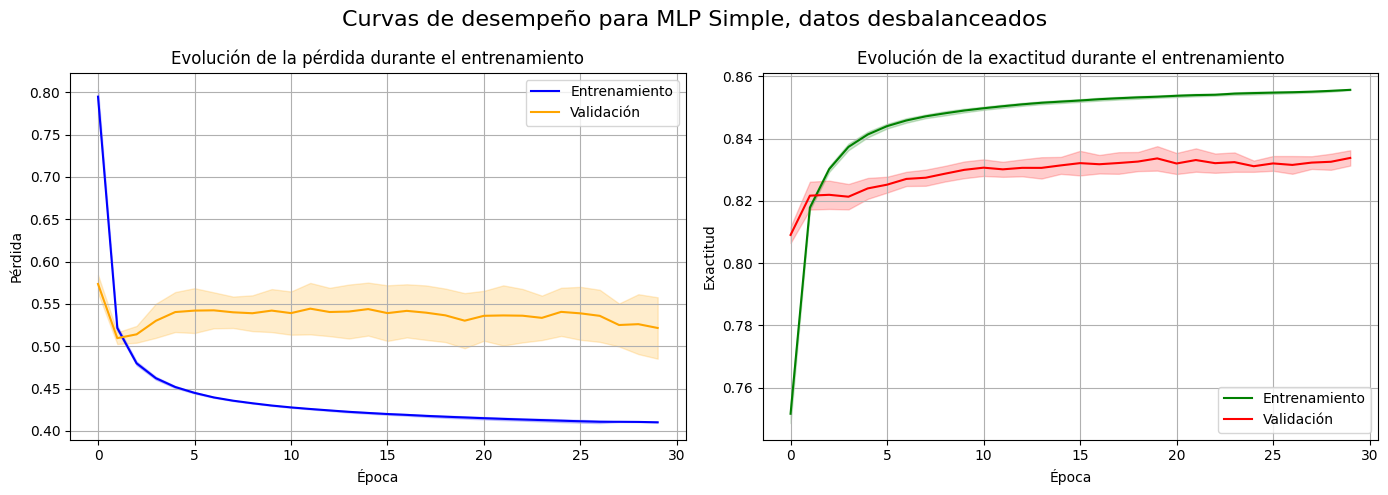

In [ ]:
# @title
import numpy as np
import matplotlib.pyplot as plt

# Ajuste para early stopping: rellenar con NaN para igualar longitudes
max_epochs = max(len(run['train_loss']) for run in curves_history)

# Padding con NaN
def pad_with_nan(runs, max_len):
    return [run + [np.nan] * (max_len - len(run)) for run in runs]

train_loss_all = np.array(pad_with_nan([run['train_loss'] for run in curves_history], max_epochs))
val_loss_all = np.array(pad_with_nan([run['val_loss'] for run in curves_history], max_epochs))
train_acc_all = np.array(pad_with_nan([run['train_acc'] for run in curves_history], max_epochs))
val_acc_all = np.array(pad_with_nan([run['val_acc'] for run in curves_history], max_epochs))

# Estadísticas
train_loss_mean = np.nanmean(train_loss_all, axis=0)
train_loss_std = np.nanstd(train_loss_all, axis=0)
val_loss_mean = np.nanmean(val_loss_all, axis=0)
val_loss_std = np.nanstd(val_loss_all, axis=0)

train_acc_mean = np.nanmean(train_acc_all, axis=0)
train_acc_std = np.nanstd(train_acc_all, axis=0)
val_acc_mean = np.nanmean(val_acc_all, axis=0)
val_acc_std = np.nanstd(val_acc_all, axis=0)

# Eje de épocas desde 0
epochs = np.arange(0, max_epochs)

# Graficar
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
fig.set_facecolor('white')
fig.suptitle("Curvas de desempeño para MLP Simple, datos desbalanceados", fontsize=16)

# --- Evolución del Loss ---
ax[0].plot(epochs, train_loss_mean, label='Entrenamiento', color='blue')
ax[0].fill_between(epochs, train_loss_mean - train_loss_std, train_loss_mean + train_loss_std, color='blue', alpha=0.2)

ax[0].plot(epochs, val_loss_mean, label='Validación', color='orange')
ax[0].fill_between(epochs, val_loss_mean - val_loss_std, val_loss_mean + val_loss_std, color='orange', alpha=0.2)

ax[0].set_xlabel('Época')
ax[0].set_ylabel('Pérdida')
ax[0].set_title('Evolución de la pérdida durante el entrenamiento')
ax[0].legend()
ax[0].grid(True)

# --- Evolución de la Accuracy ---
ax[1].plot(epochs, train_acc_mean, label='Entrenamiento', color='green')
ax[1].fill_between(epochs, train_acc_mean - train_acc_std, train_acc_mean + train_acc_std, color='green', alpha=0.2)

ax[1].plot(epochs, val_acc_mean, label='Validación', color='red')
ax[1].fill_between(epochs, val_acc_mean - val_acc_std, val_acc_mean + val_acc_std, color='red', alpha=0.2)

ax[1].set_xlabel('Época')
ax[1].set_ylabel('Exactitud')
ax[1].set_title('Evolución de la exactitud durante el entrenamiento')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

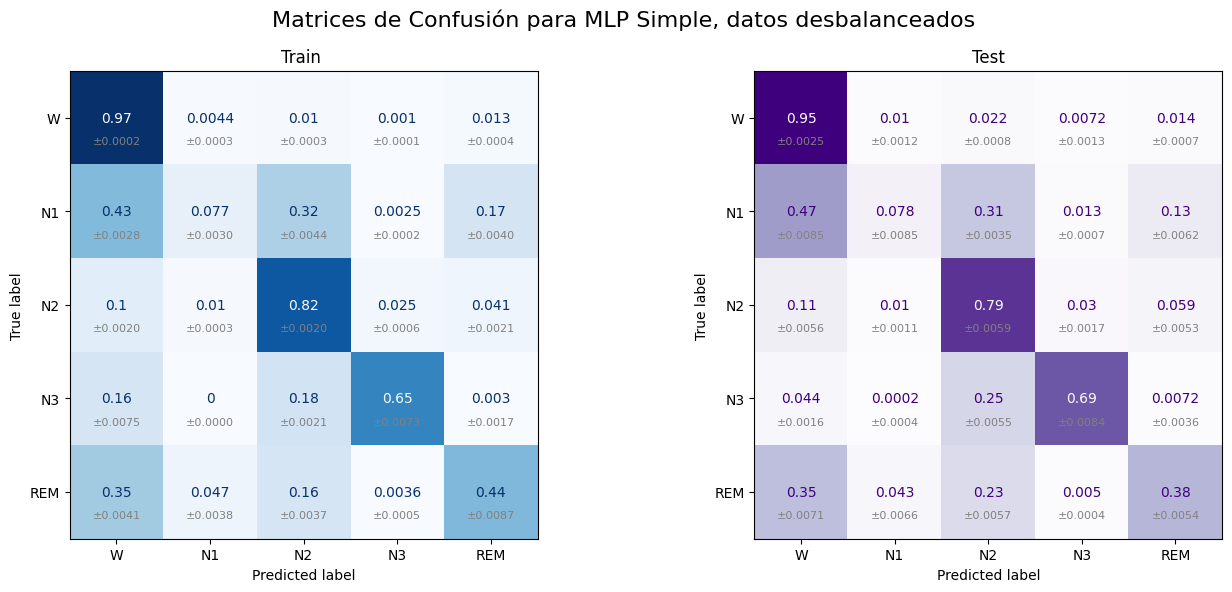

In [ ]:
# @title
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# TRAIN
# Access the list of confusion matrices stored per epoch
train_matrices = np.array([run['train_cm'][-1] for run in curves_history])
train_matrices_norm = np.array([cm / cm.sum(axis=1, keepdims=True) for cm in train_matrices])
train_mean = np.nanmean(train_matrices_norm, axis=0) # Use nanmean to handle potential NaNs from normalization
train_std = np.nanstd(train_matrices_norm, axis=0) # Use nanstd

# TEST
test_matrices = np.array(test_cm_history)
test_mean = test_matrices.mean(axis=0)
test_std = test_matrices.std(axis=0)

# Visualización
class_names = ["W", "N1", "N2", "N3", "REM"]
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Matrices de Confusión para MLP Simple, datos desbalanceados", fontsize=16)

# TRAIN
disp_train = ConfusionMatrixDisplay(train_mean, display_labels=class_names)
disp_train.plot(ax=ax[0], cmap="Blues", colorbar=False)
ax[0].set_title("Train ")
for (i, j), val in np.ndenumerate(train_mean):
    ax[0].text(j, i + 0.25, f"±{train_std[i, j]:.4f}", ha="center", va="center", fontsize=8, color="gray")

# TEST
disp_test = ConfusionMatrixDisplay(test_mean, display_labels=class_names)
disp_test.plot(ax=ax[1], cmap="Purples", colorbar=False)
ax[1].set_title("Test")
for (i, j), val in np.ndenumerate(test_mean):
    ax[1].text(j, i + 0.25, f"±{test_std[i, j]:.4f}", ha="center", va="center", fontsize=8, color="gray")

plt.tight_layout()
plt.show()

In [ ]:
# @title
import numpy as np
import pandas as pd
from IPython.display import display

# Nombres de las clases
class_names = ["W", "N1", "N2", "N3", "REM"]

# Inicializar listas para métricas por clase
precision_list = {name: [] for name in class_names}
recall_list = {name: [] for name in class_names}
f1_list = {name: [] for name in class_names}
accuracy_list = []

# Calcular métricas por iteración usando test_cm_history
for cm in test_cm_history:
    acc = np.trace(cm) / cm.shape[0]
    accuracy_list.append(acc)

    for i, name in enumerate(class_names):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP

        precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

        precision_list[name].append(precision)
        recall_list[name].append(recall)
        f1_list[name].append(f1)

# Crear DataFrame con métricas promedio ± std
data = []
for name in class_names:
    p_mean = np.mean(precision_list[name])
    p_std = np.std(precision_list[name])
    r_mean = np.mean(recall_list[name])
    r_std = np.std(recall_list[name])
    f_mean = np.mean(f1_list[name])
    f_std = np.std(f1_list[name])
    data.append([
        f"{p_mean:.4f} ± {p_std:.4f}",
        f"{r_mean:.4f} ± {r_std:.4f}",
        f"{f_mean:.4f} ± {f_std:.4f}"
    ])

# Agregar accuracy global
acc_mean = np.mean(accuracy_list)
acc_std = np.std(accuracy_list)
data.append([
    f"{acc_mean:.4f} ± {acc_std:.4f}",
    "",
    ""
])

# Crear tabla como DataFrame
df_metrics = pd.DataFrame(data, columns=["Precisión", "Recall", "F1-score"], index=class_names + ["Accuracy Global"])

# Mostrar tabla en notebook
display(df_metrics)

,Precisión,Recall,F1-score
W,0.4949 ± 0.0044,0.9468 ± 0.0025,0.6500 ± 0.0034
N1,0.5510 ± 0.0070,0.0782 ± 0.0085,0.1368 ± 0.0130
N2,0.4921 ± 0.0024,0.7921 ± 0.0059,0.6071 ± 0.0024
N3,0.9274 ± 0.0026,0.6942 ± 0.0084,0.7940 ± 0.0050
REM,0.6399 ± 0.0089,0.3750 ± 0.0054,0.4728 ± 0.0026
Accuracy Global,0.5773 ± 0.0025,,


### Balanceado

In [ ]:
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn

# Parámetros de entrenamiento
lr = 5e-4
dropout_p = 0.35
batch_size = 256
criterion = nn.CrossEntropyLoss()
epochs = 30

# Inicialización
curves_history = []
test_acc_history = []
test_cm_history = []

# Entrenamiento con evaluación en test por iteración
for i in range(5):
    print(f"Iteración N° {i+1}")

    model = SimpleMLPModel()

    curves = train_model(
        model=model,
        train_dataset=train_dataset_balanceado,
        val_dataset=val_dataset,
        max_epochs=epochs,
        criterion=criterion,
        batch_size=batch_size,
        lr=lr,
        n_evaluations_per_epoch=5,
        use_gpu=False
    )

    # Evaluación en test
    model.eval()
    with torch.no_grad():
        y_test_pred = model(X_test)
        test_pred_labels = torch.argmax(y_test_pred, axis=1)
        test_acc = (test_pred_labels == y_test).float().mean().item()
        test_acc_history.append(test_acc)

        # Matriz de confusión normalizada
        cm_test = confusion_matrix(y_test.numpy(), test_pred_labels.numpy(), labels=np.arange(5), normalize='true')
        test_cm_history.append(cm_test)

    print()
    curves_history.append(curves)

# Estadísticas finales
test_acc_history = np.array(test_acc_history)
test_acc_mean = test_acc_history.mean()
test_acc_std = test_acc_history.std()

Iteración N° 1
Epoch 1/30 - Batch 130/652 Iteration 130 - Batch 130/652 - Train loss: 1.4851333703703553, Train acc: 0.41606035305343514
Epoch 1/30 - Batch 260/652 Iteration 260 - Batch 260/652 - Train loss: 1.3694988283617744, Train acc: 0.485422653256705
Epoch 1/30 - Batch 390/652 Iteration 390 - Batch 390/652 - Train loss: 1.284092975851825, Train acc: 0.5228880274936062
Epoch 1/30 - Batch 520/652 Iteration 520 - Batch 520/652 - Train loss: 1.2192301555695781, Train acc: 0.5495966290786948
Epoch 1/30 - Batch 650/652 Iteration 650 - Batch 650/652 - Train loss: 1.1670902083912569, Train acc: 0.5681043586789555
Epoch 1/30 - Batch 651/652  - Train loss: 1.1666624557935388, Train acc: 0.5681480148734557, Val loss: 1.0915216207504272, Val acc: 0.519034743309021
Epoch 2/30 - Batch 130/652 Iteration 782 - Batch 130/652 - Train loss: 0.9192082759078223, Train acc: 0.6576216603053435
Epoch 2/30 - Batch 260/652 Iteration 912 - Batch 260/652 - Train loss: 0.9045231696289618, Train acc: 0.662640

####Métricas de desempeño

In [ ]:
# @title
import numpy as np

# Accuracy en entrenamiento
train_acc_history = np.array([run['train_acc'][-1] for run in curves_history])
train_acc_mean = train_acc_history.mean()
train_acc_std = train_acc_history.std()
print('Accuracy final en entrenamiento: %.4f ± %.4f' % (train_acc_mean, train_acc_std))
#print("Historial de entrenamiento:", np.round(train_acc_history, 4))


# Accuracy en validación
val_acc_history = np.array([run['val_acc'][-1] for run in curves_history])
val_acc_mean = val_acc_history.mean()
val_acc_std = val_acc_history.std()
print('Accuracy final en validación: %.4f ± %.4f' % (val_acc_mean, val_acc_std))
#print("Historial de validación:", np.round(val_acc_history, 4))

# Accuracy en test
test_acc_history = np.array(test_acc_history)
test_acc_mean = test_acc_history.mean()
test_acc_std = test_acc_history.std()
print('Accuracy final en test: %.4f ± %.4f' % (test_acc_mean, test_acc_std))
#print("Historial de test:", np.round(test_acc_history, 4))

Accuracy final en entrenamiento: 0.7340 ± 0.0006
Accuracy final en validación: 0.5865 ± 0.0048
Accuracy final en test: 0.5935 ± 0.0031


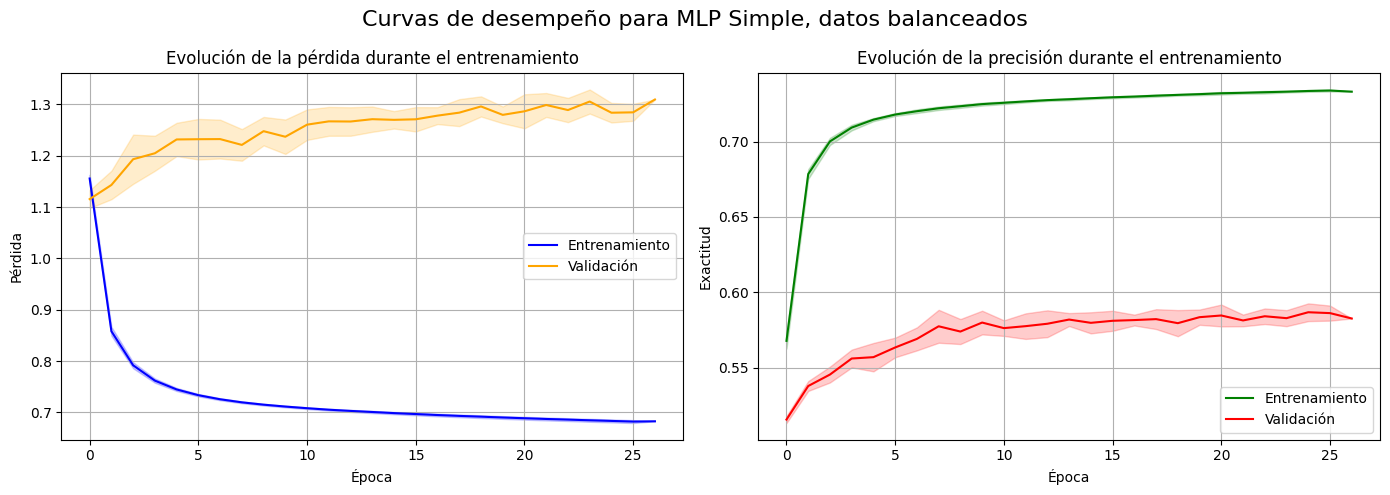

In [ ]:
# @title
import numpy as np
import matplotlib.pyplot as plt

# Ajuste para early stopping: rellenar con NaN para igualar longitudes
max_epochs = max(len(run['train_loss']) for run in curves_history)

# Padding con NaN
def pad_with_nan(runs, max_len):
    return [run + [np.nan] * (max_len - len(run)) for run in runs]

train_loss_all = np.array(pad_with_nan([run['train_loss'] for run in curves_history], max_epochs))
val_loss_all = np.array(pad_with_nan([run['val_loss'] for run in curves_history], max_epochs))
train_acc_all = np.array(pad_with_nan([run['train_acc'] for run in curves_history], max_epochs))
val_acc_all = np.array(pad_with_nan([run['val_acc'] for run in curves_history], max_epochs))

# Estadísticas
train_loss_mean = np.nanmean(train_loss_all, axis=0)
train_loss_std = np.nanstd(train_loss_all, axis=0)
val_loss_mean = np.nanmean(val_loss_all, axis=0)
val_loss_std = np.nanstd(val_loss_all, axis=0)

train_acc_mean = np.nanmean(train_acc_all, axis=0)
train_acc_std = np.nanstd(train_acc_all, axis=0)
val_acc_mean = np.nanmean(val_acc_all, axis=0)
val_acc_std = np.nanstd(val_acc_all, axis=0)

# Eje de épocas desde 0
epochs = np.arange(0, max_epochs)

# Graficar
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
fig.set_facecolor('white')
fig.suptitle("Curvas de desempeño para MLP Simple, datos balanceados", fontsize=16)

# --- Evolución del Loss ---
ax[0].plot(epochs, train_loss_mean, label='Entrenamiento', color='blue')
ax[0].fill_between(epochs, train_loss_mean - train_loss_std, train_loss_mean + train_loss_std, color='blue', alpha=0.2)

ax[0].plot(epochs, val_loss_mean, label='Validación', color='orange')
ax[0].fill_between(epochs, val_loss_mean - val_loss_std, val_loss_mean + val_loss_std, color='orange', alpha=0.2)

ax[0].set_xlabel('Época')
ax[0].set_ylabel('Pérdida')
ax[0].set_title('Evolución de la pérdida durante el entrenamiento')
ax[0].legend()
ax[0].grid(True)

# --- Evolución de la Accuracy ---
ax[1].plot(epochs, train_acc_mean, label='Entrenamiento', color='green')
ax[1].fill_between(epochs, train_acc_mean - train_acc_std, train_acc_mean + train_acc_std, color='green', alpha=0.2)

ax[1].plot(epochs, val_acc_mean, label='Validación', color='red')
ax[1].fill_between(epochs, val_acc_mean - val_acc_std, val_acc_mean + val_acc_std, color='red', alpha=0.2)

ax[1].set_xlabel('Época')
ax[1].set_ylabel('Exactitud')
ax[1].set_title('Evolución de la precisión durante el entrenamiento')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

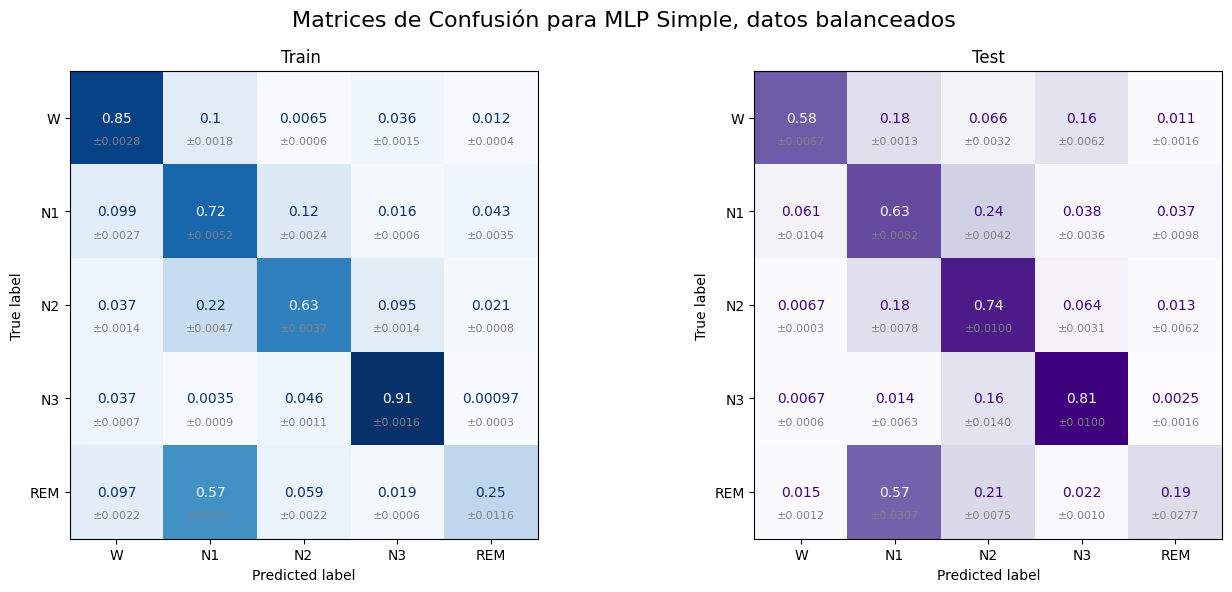

In [ ]:
# @title
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# TRAIN
# Access the list of confusion matrices stored per epoch
train_matrices = np.array([run['train_cm'][-1] for run in curves_history])
train_matrices_norm = np.array([cm / cm.sum(axis=1, keepdims=True) for cm in train_matrices])
train_mean = np.nanmean(train_matrices_norm, axis=0) # Use nanmean to handle potential NaNs from normalization
train_std = np.nanstd(train_matrices_norm, axis=0) # Use nanstd

# TEST
test_matrices = np.array(test_cm_history)
test_mean = test_matrices.mean(axis=0)
test_std = test_matrices.std(axis=0)

# Visualización
class_names = ["W", "N1", "N2", "N3", "REM"]
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Matrices de Confusión para MLP Simple, datos balanceados", fontsize=16)

# TRAIN
disp_train = ConfusionMatrixDisplay(train_mean, display_labels=class_names)
disp_train.plot(ax=ax[0], cmap="Blues", colorbar=False)
ax[0].set_title("Train ")
for (i, j), val in np.ndenumerate(train_mean):
    ax[0].text(j, i + 0.25, f"±{train_std[i, j]:.4f}", ha="center", va="center", fontsize=8, color="gray")

# TEST
disp_test = ConfusionMatrixDisplay(test_mean, display_labels=class_names)
disp_test.plot(ax=ax[1], cmap="Purples", colorbar=False)
ax[1].set_title("Test")
for (i, j), val in np.ndenumerate(test_mean):
    ax[1].text(j, i + 0.25, f"±{test_std[i, j]:.4f}", ha="center", va="center", fontsize=8, color="gray")

plt.tight_layout()
plt.show()

In [ ]:
# @title
import numpy as np
import pandas as pd
from IPython.display import display

# Nombres de las clases
class_names = ["W", "N1", "N2", "N3", "REM"]

# Inicializar listas para métricas por clase
precision_list = {name: [] for name in class_names}
recall_list = {name: [] for name in class_names}
f1_list = {name: [] for name in class_names}
accuracy_list = []

# Calcular métricas por iteración usando test_cm_history
for cm in test_cm_history:
    acc = np.trace(cm) / cm.shape[0]
    accuracy_list.append(acc)

    for i, name in enumerate(class_names):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP

        precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

        precision_list[name].append(precision)
        recall_list[name].append(recall)
        f1_list[name].append(f1)

# Crear DataFrame con métricas promedio ± std
data = []
for name in class_names:
    p_mean = np.mean(precision_list[name])
    p_std = np.std(precision_list[name])
    r_mean = np.mean(recall_list[name])
    r_std = np.std(recall_list[name])
    f_mean = np.mean(f1_list[name])
    f_std = np.std(f1_list[name])
    data.append([
        f"{p_mean:.4f} ± {p_std:.4f}",
        f"{r_mean:.4f} ± {r_std:.4f}",
        f"{f_mean:.4f} ± {f_std:.4f}"
    ])

# Agregar accuracy global
acc_mean = np.mean(accuracy_list)
acc_std = np.std(accuracy_list)
data.append([
    f"{acc_mean:.4f} ± {acc_std:.4f}",
    "",
    ""
])

# Crear tabla como DataFrame
df_metrics = pd.DataFrame(data, columns=["Precisión", "Recall", "F1-score"], index=class_names + ["Accuracy Global"])

# Mostrar tabla en notebook
display(df_metrics)

,Precisión,Recall,F1-score
W,0.8684 ± 0.0131,0.5842 ± 0.0067,0.6984 ± 0.0048
N1,0.4018 ± 0.0105,0.6269 ± 0.0082,0.4896 ± 0.0082
N2,0.5234 ± 0.0050,0.7393 ± 0.0100,0.6128 ± 0.0026
N3,0.7392 ± 0.0063,0.8140 ± 0.0100,0.7748 ± 0.0073
REM,0.7457 ± 0.0300,0.1873 ± 0.0277,0.2982 ± 0.0349
Accuracy Global,0.5903 ± 0.0050,,


##MLP Mejorado

###Desbalanceado

In [ ]:
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn

# Parámetros de entrenamiento
lr = 5e-4
dropout_p = 0.40
batch_size = 256
criterion = nn.CrossEntropyLoss()
epochs = 30

# Inicialización
curves_history = []
test_acc_history = []
test_cm_history = []

# Entrenamiento con evaluación en test por iteración
for i in range(5):
    print(f"Iteración N° {i+1}")

    model = MLPModel(dropout_p)

    curves = train_model(
        model=model,
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        max_epochs=epochs,
        criterion=criterion,
        batch_size=batch_size,
        lr=lr,
        n_evaluations_per_epoch=5,
        early_stopping_tolerance=20,
        use_gpu=False
    )

    # Evaluación en test
    model.eval()
    with torch.no_grad():
        y_test_pred = model(X_test)
        test_pred_labels = torch.argmax(y_test_pred, axis=1)
        test_acc = (test_pred_labels == y_test).float().mean().item()
        test_acc_history.append(test_acc)

        # Matriz de confusión normalizada
        cm_test = confusion_matrix(y_test.numpy(), test_pred_labels.numpy(), labels=np.arange(5), normalize='true')
        test_cm_history.append(cm_test)

    print()
    curves_history.append(curves)

# Estadísticas finales
test_acc_history = np.array(test_acc_history)
test_acc_mean = test_acc_history.mean()
test_acc_std = test_acc_history.std()

Iteración N° 1
Epoch 1/30 - Batch 193/966 Iteration 193 - Batch 193/966 - Train loss: 0.9379962243370175, Train acc: 0.6834125322164949
Epoch 1/30 - Batch 386/966 Iteration 386 - Batch 386/966 - Train loss: 0.7678614184067847, Train acc: 0.7375645994832042
Epoch 1/30 - Batch 579/966 Iteration 579 - Batch 579/966 - Train loss: 0.6978933063560518, Train acc: 0.7587015086206896
Epoch 1/30 - Batch 772/966 Iteration 772 - Batch 772/966 - Train loss: 0.6593890433786449, Train acc: 0.77034484152652
Epoch 1/30 - Batch 965/966 Iteration 965 - Batch 965/966 - Train loss: 0.6298014587620524, Train acc: 0.7795087242128781
 - Train loss: 0.6298014587620524, Train acc: 0.7795087242128781, Val loss: 0.46748045086860657, Val acc: 0.832675576210022
Epoch 2/30 - Batch 193/966 Iteration 1159 - Batch 193/966 - Train loss: 0.5055364582341971, Train acc: 0.819104381443299
Epoch 2/30 - Batch 386/966 Iteration 1352 - Batch 386/966 - Train loss: 0.5076752517574518, Train acc: 0.8181120801033591
Epoch 2/30 - Ba

####Métricas de desempeño

In [ ]:
# @title
import numpy as np

# Accuracy en entrenamiento
train_acc_history = np.array([run['train_acc'][-1] for run in curves_history])
train_acc_mean = train_acc_history.mean()
train_acc_std = train_acc_history.std()
print('Accuracy final en entrenamiento: %.4f ± %.4f' % (train_acc_mean, train_acc_std))
#print("Historial de entrenamiento:", np.round(train_acc_history, 4))


# Accuracy en validación
val_acc_history = np.array([run['val_acc'][-1] for run in curves_history])
val_acc_mean = val_acc_history.mean()
val_acc_std = val_acc_history.std()
print('Accuracy final en validación: %.4f ± %.4f' % (val_acc_mean, val_acc_std))
#print("Historial de validación:", np.round(val_acc_history, 4))

# Accuracy en test
test_acc_history = np.array(test_acc_history)
test_acc_mean = test_acc_history.mean()
test_acc_std = test_acc_history.std()
print('Accuracy final en test: %.4f ± %.4f' % (test_acc_mean, test_acc_std))
#print("Historial de test:", np.round(test_acc_history, 4))

Accuracy final en entrenamiento: 0.8484 ± 0.0002
Accuracy final en validación: 0.8494 ± 0.0027
Accuracy final en test: 0.8367 ± 0.0012


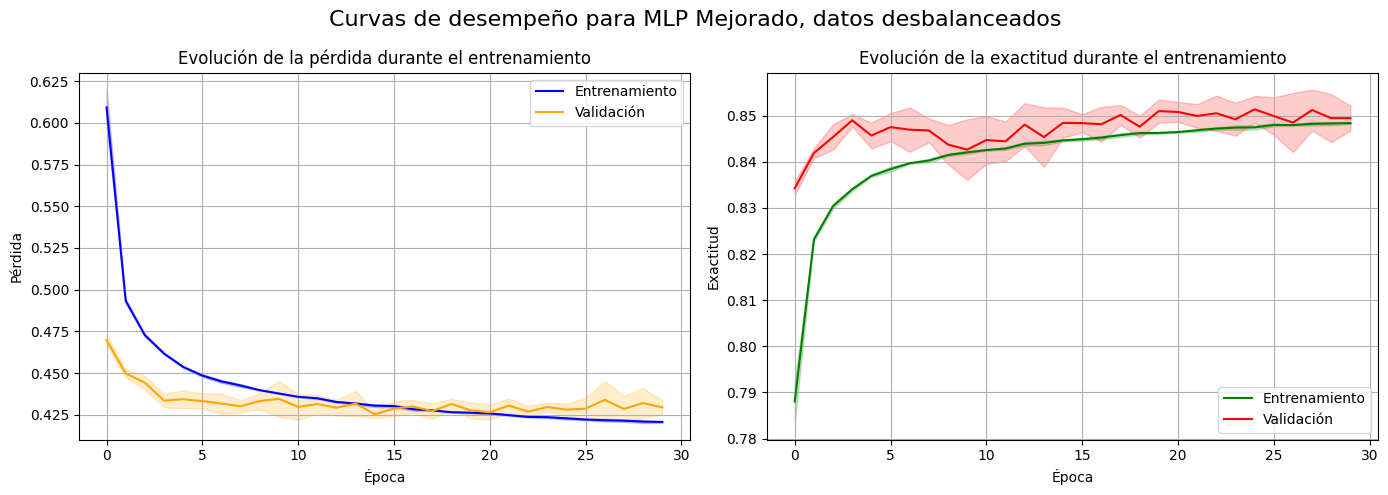

In [ ]:
# @title
import numpy as np
import matplotlib.pyplot as plt

# Ajuste para early stopping: rellenar con NaN para igualar longitudes
max_epochs = max(len(run['train_loss']) for run in curves_history)

# Padding con NaN
def pad_with_nan(runs, max_len):
    return [run + [np.nan] * (max_len - len(run)) for run in runs]

train_loss_all = np.array(pad_with_nan([run['train_loss'] for run in curves_history], max_epochs))
val_loss_all = np.array(pad_with_nan([run['val_loss'] for run in curves_history], max_epochs))
train_acc_all = np.array(pad_with_nan([run['train_acc'] for run in curves_history], max_epochs))
val_acc_all = np.array(pad_with_nan([run['val_acc'] for run in curves_history], max_epochs))

# Estadísticas
train_loss_mean = np.nanmean(train_loss_all, axis=0)
train_loss_std = np.nanstd(train_loss_all, axis=0)
val_loss_mean = np.nanmean(val_loss_all, axis=0)
val_loss_std = np.nanstd(val_loss_all, axis=0)

train_acc_mean = np.nanmean(train_acc_all, axis=0)
train_acc_std = np.nanstd(train_acc_all, axis=0)
val_acc_mean = np.nanmean(val_acc_all, axis=0)
val_acc_std = np.nanstd(val_acc_all, axis=0)

# Eje de épocas desde 0
epochs = np.arange(0, max_epochs)

# Graficar
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
fig.set_facecolor('white')
fig.suptitle("Curvas de desempeño para MLP Mejorado, datos desbalanceados", fontsize=16)

# --- Evolución del Loss ---
ax[0].plot(epochs, train_loss_mean, label='Entrenamiento', color='blue')
ax[0].fill_between(epochs, train_loss_mean - train_loss_std, train_loss_mean + train_loss_std, color='blue', alpha=0.2)

ax[0].plot(epochs, val_loss_mean, label='Validación', color='orange')
ax[0].fill_between(epochs, val_loss_mean - val_loss_std, val_loss_mean + val_loss_std, color='orange', alpha=0.2)

ax[0].set_xlabel('Época')
ax[0].set_ylabel('Pérdida')
ax[0].set_title('Evolución de la pérdida durante el entrenamiento')
ax[0].legend()
ax[0].grid(True)

# --- Evolución de la Accuracy ---
ax[1].plot(epochs, train_acc_mean, label='Entrenamiento', color='green')
ax[1].fill_between(epochs, train_acc_mean - train_acc_std, train_acc_mean + train_acc_std, color='green', alpha=0.2)

ax[1].plot(epochs, val_acc_mean, label='Validación', color='red')
ax[1].fill_between(epochs, val_acc_mean - val_acc_std, val_acc_mean + val_acc_std, color='red', alpha=0.2)

ax[1].set_xlabel('Época')
ax[1].set_ylabel('Exactitud')
ax[1].set_title('Evolución de la exactitud durante el entrenamiento')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

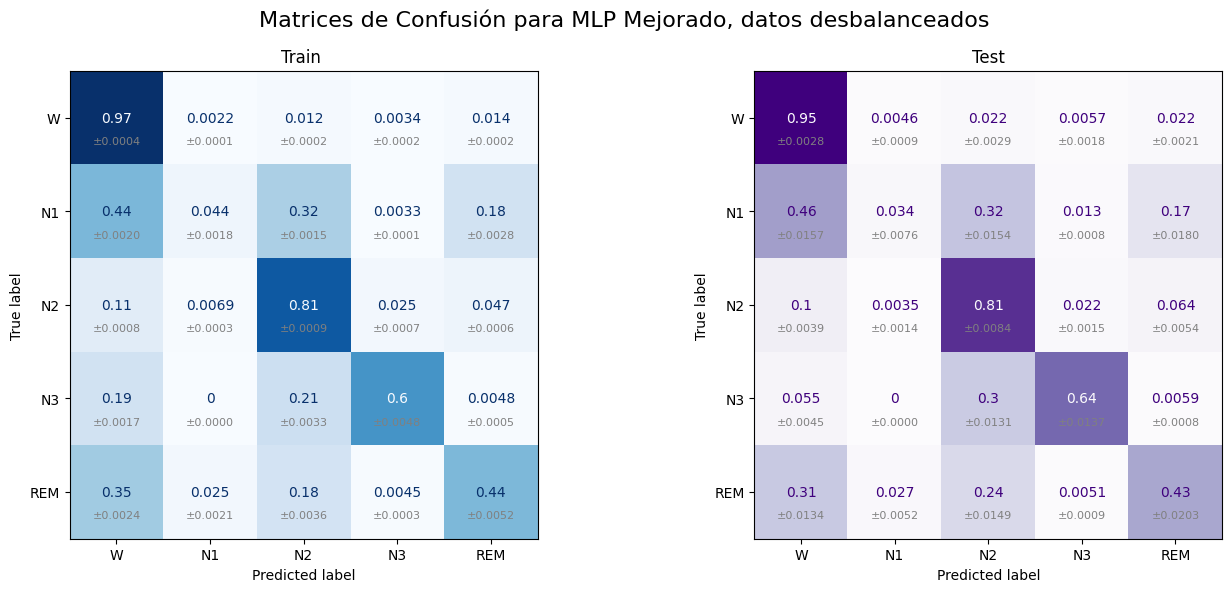

In [ ]:
# @title
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# TRAIN
# Access the list of confusion matrices stored per epoch
train_matrices = np.array([run['train_cm'][-1] for run in curves_history])
train_matrices_norm = np.array([cm / cm.sum(axis=1, keepdims=True) for cm in train_matrices])
train_mean = np.nanmean(train_matrices_norm, axis=0) # Use nanmean to handle potential NaNs from normalization
train_std = np.nanstd(train_matrices_norm, axis=0) # Use nanstd

# TEST
test_matrices = np.array(test_cm_history)
test_mean = test_matrices.mean(axis=0)
test_std = test_matrices.std(axis=0)

# Visualización
class_names = ["W", "N1", "N2", "N3", "REM"]
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Matrices de Confusión para MLP Mejorado, datos desbalanceados", fontsize=16)

# TRAIN
disp_train = ConfusionMatrixDisplay(train_mean, display_labels=class_names)
disp_train.plot(ax=ax[0], cmap="Blues", colorbar=False)
ax[0].set_title("Train ")
for (i, j), val in np.ndenumerate(train_mean):
    ax[0].text(j, i + 0.25, f"±{train_std[i, j]:.4f}", ha="center", va="center", fontsize=8, color="gray")

# TEST
disp_test = ConfusionMatrixDisplay(test_mean, display_labels=class_names)
disp_test.plot(ax=ax[1], cmap="Purples", colorbar=False)
ax[1].set_title("Test")
for (i, j), val in np.ndenumerate(test_mean):
    ax[1].text(j, i + 0.25, f"±{test_std[i, j]:.4f}", ha="center", va="center", fontsize=8, color="gray")

plt.tight_layout()
plt.show()

In [ ]:
# @title
import numpy as np
import pandas as pd
from IPython.display import display

# Nombres de las clases
class_names = ["W", "N1", "N2", "N3", "REM"]

# Inicializar listas para métricas por clase
precision_list = {name: [] for name in class_names}
recall_list = {name: [] for name in class_names}
f1_list = {name: [] for name in class_names}
accuracy_list = []

# Calcular métricas por iteración usando test_cm_history
for cm in test_cm_history:
    acc = np.trace(cm) / cm.shape[0]
    accuracy_list.append(acc)

    for i, name in enumerate(class_names):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP

        precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

        precision_list[name].append(precision)
        recall_list[name].append(recall)
        f1_list[name].append(f1)

# Crear DataFrame con métricas promedio ± std
data = []
for name in class_names:
    p_mean = np.mean(precision_list[name])
    p_std = np.std(precision_list[name])
    r_mean = np.mean(recall_list[name])
    r_std = np.std(recall_list[name])
    f_mean = np.mean(f1_list[name])
    f_std = np.std(f1_list[name])
    data.append([
        f"{p_mean:.4f} ± {p_std:.4f}",
        f"{r_mean:.4f} ± {r_std:.4f}",
        f"{f_mean:.4f} ± {f_std:.4f}"
    ])

# Agregar accuracy global
acc_mean = np.mean(accuracy_list)
acc_std = np.std(accuracy_list)
data.append([
    f"{acc_mean:.4f} ± {acc_std:.4f}",
    "",
    ""
])

# Crear tabla como DataFrame
df_metrics = pd.DataFrame(data, columns=["Precisión", "Recall", "F1-score"], index=class_names + ["Accuracy Global"])

# Mostrar tabla en notebook
display(df_metrics)

,Precisión,Recall,F1-score
W,0.5063 ± 0.0081,0.9459 ± 0.0028,0.6595 ± 0.0064
N1,0.4922 ± 0.0141,0.0337 ± 0.0076,0.0630 ± 0.0134
N2,0.4787 ± 0.0077,0.8055 ± 0.0084,0.6004 ± 0.0039
N3,0.9330 ± 0.0046,0.6433 ± 0.0137,0.7614 ± 0.0085
REM,0.6172 ± 0.0124,0.4254 ± 0.0203,0.5031 ± 0.0111
Accuracy Global,0.5708 ± 0.0042,,


### Balanceado

In [ ]:
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn

# Parámetros de entrenamiento
lr = 5e-4
dropout_p = 0.40
batch_size = 256
criterion = nn.CrossEntropyLoss()
epochs = 30

# Inicialización
curves_history = []
test_acc_history = []
test_cm_history = []

# Entrenamiento con evaluación en test por iteración
for i in range(5):
    print(f"Iteración N° {i+1}")

    model = MLPModel(dropout_p)

    curves = train_model(
        model=model,
        train_dataset=train_dataset_balanceado,
        val_dataset=val_dataset,
        max_epochs=epochs,
        criterion=criterion,
        batch_size=batch_size,
        lr=lr,
        n_evaluations_per_epoch=5,
        early_stopping_tolerance=20,
        use_gpu=False
    )

    # Evaluación en test
    model.eval()
    with torch.no_grad():
        y_test_pred = model(X_test)
        test_pred_labels = torch.argmax(y_test_pred, axis=1)
        test_acc = (test_pred_labels == y_test).float().mean().item()
        test_acc_history.append(test_acc)

        # Matriz de confusión normalizada
        cm_test = confusion_matrix(y_test.numpy(), test_pred_labels.numpy(), labels=np.arange(5), normalize='true')
        test_cm_history.append(cm_test)

    print()
    curves_history.append(curves)

# Estadísticas finales
test_acc_history = np.array(test_acc_history)
test_acc_mean = test_acc_history.mean()
test_acc_std = test_acc_history.std()

Iteración N° 1
Epoch 1/30 - Batch 130/652 Iteration 130 - Batch 130/652 - Train loss: 1.156784754218036, Train acc: 0.5404341603053435
Epoch 1/30 - Batch 260/652 Iteration 260 - Batch 260/652 - Train loss: 1.0519630630354315, Train acc: 0.5806842672413793
Epoch 1/30 - Batch 390/652 Iteration 390 - Batch 390/652 - Train loss: 0.9983857199359123, Train acc: 0.6019721067774936
Epoch 1/30 - Batch 520/652 Iteration 520 - Batch 520/652 - Train loss: 0.9658645004777671, Train acc: 0.6149082293666027
Epoch 1/30 - Batch 650/652 Iteration 650 - Batch 650/652 - Train loss: 0.9416151617162971, Train acc: 0.624459965437788
Epoch 1/30 - Batch 651/652  - Train loss: 0.9413726835345929, Train acc: 0.6244872256207269, Val loss: 0.9929357767105103, Val acc: 0.5798051953315735
Epoch 2/30 - Batch 130/652 Iteration 782 - Batch 130/652 - Train loss: 0.824626307451088, Train acc: 0.6715469942748091
Epoch 2/30 - Batch 260/652 Iteration 912 - Batch 260/652 - Train loss: 0.8169928021814631, Train acc: 0.6765744

####Métricas de desempeño

In [ ]:
# @title
import numpy as np

# Accuracy en entrenamiento
train_acc_history = np.array([run['train_acc'][-1] for run in curves_history])
train_acc_mean = train_acc_history.mean()
train_acc_std = train_acc_history.std()
print('Accuracy final en entrenamiento: %.4f ± %.4f' % (train_acc_mean, train_acc_std))
#print("Historial de entrenamiento:", np.round(train_acc_history, 4))


# Accuracy en validación
val_acc_history = np.array([run['val_acc'][-1] for run in curves_history])
val_acc_mean = val_acc_history.mean()
val_acc_std = val_acc_history.std()
print('Accuracy final en validación: %.4f ± %.4f' % (val_acc_mean, val_acc_std))
#print("Historial de validación:", np.round(val_acc_history, 4))

# Accuracy en test
test_acc_history = np.array(test_acc_history)
test_acc_mean = test_acc_history.mean()
test_acc_std = test_acc_history.std()
print('Accuracy final en test: %.4f ± %.4f' % (test_acc_mean, test_acc_std))
#print("Historial de test:", np.round(test_acc_history, 4))

Accuracy final en entrenamiento: 0.7246 ± 0.0009
Accuracy final en validación: 0.5857 ± 0.0074
Accuracy final en test: 0.5931 ± 0.0061


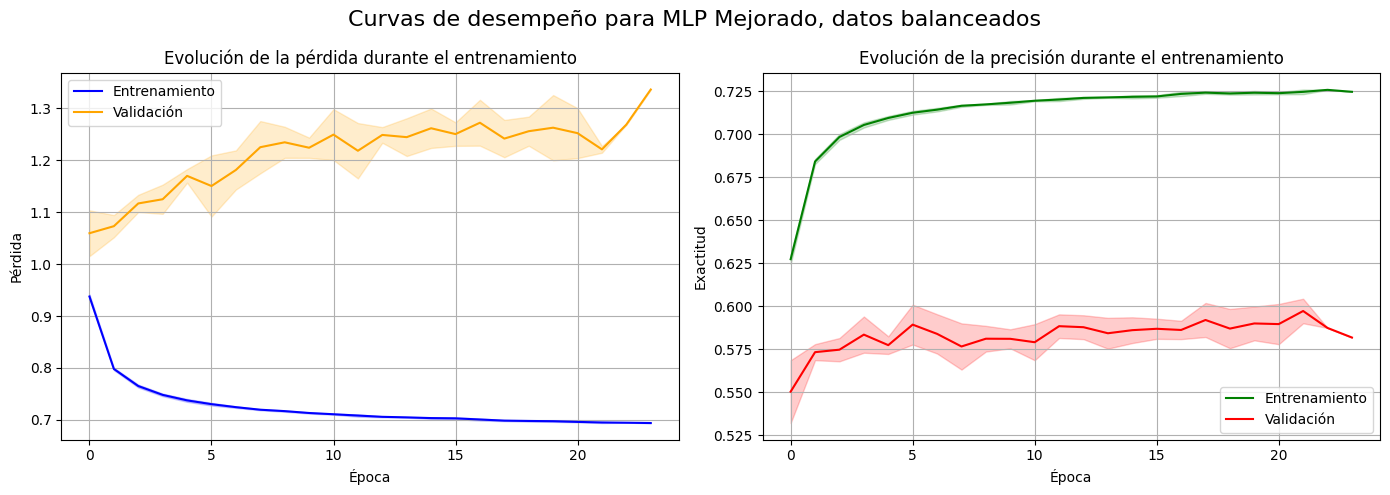

In [ ]:
# @title
import numpy as np
import matplotlib.pyplot as plt

# Ajuste para early stopping: rellenar con NaN para igualar longitudes
max_epochs = max(len(run['train_loss']) for run in curves_history)

# Padding con NaN
def pad_with_nan(runs, max_len):
    return [run + [np.nan] * (max_len - len(run)) for run in runs]

train_loss_all = np.array(pad_with_nan([run['train_loss'] for run in curves_history], max_epochs))
val_loss_all = np.array(pad_with_nan([run['val_loss'] for run in curves_history], max_epochs))
train_acc_all = np.array(pad_with_nan([run['train_acc'] for run in curves_history], max_epochs))
val_acc_all = np.array(pad_with_nan([run['val_acc'] for run in curves_history], max_epochs))

# Estadísticas
train_loss_mean = np.nanmean(train_loss_all, axis=0)
train_loss_std = np.nanstd(train_loss_all, axis=0)
val_loss_mean = np.nanmean(val_loss_all, axis=0)
val_loss_std = np.nanstd(val_loss_all, axis=0)

train_acc_mean = np.nanmean(train_acc_all, axis=0)
train_acc_std = np.nanstd(train_acc_all, axis=0)
val_acc_mean = np.nanmean(val_acc_all, axis=0)
val_acc_std = np.nanstd(val_acc_all, axis=0)

# Eje de épocas desde 0
epochs = np.arange(0, max_epochs)

# Graficar
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
fig.set_facecolor('white')
fig.suptitle("Curvas de desempeño para MLP Mejorado, datos balanceados", fontsize=16)

# --- Evolución del Loss ---
ax[0].plot(epochs, train_loss_mean, label='Entrenamiento', color='blue')
ax[0].fill_between(epochs, train_loss_mean - train_loss_std, train_loss_mean + train_loss_std, color='blue', alpha=0.2)

ax[0].plot(epochs, val_loss_mean, label='Validación', color='orange')
ax[0].fill_between(epochs, val_loss_mean - val_loss_std, val_loss_mean + val_loss_std, color='orange', alpha=0.2)

ax[0].set_xlabel('Época')
ax[0].set_ylabel('Pérdida')
ax[0].set_title('Evolución de la pérdida durante el entrenamiento')
ax[0].legend()
ax[0].grid(True)

# --- Evolución de la Accuracy ---
ax[1].plot(epochs, train_acc_mean, label='Entrenamiento', color='green')
ax[1].fill_between(epochs, train_acc_mean - train_acc_std, train_acc_mean + train_acc_std, color='green', alpha=0.2)

ax[1].plot(epochs, val_acc_mean, label='Validación', color='red')
ax[1].fill_between(epochs, val_acc_mean - val_acc_std, val_acc_mean + val_acc_std, color='red', alpha=0.2)

ax[1].set_xlabel('Época')
ax[1].set_ylabel('Exactitud')
ax[1].set_title('Evolución de la precisión durante el entrenamiento')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

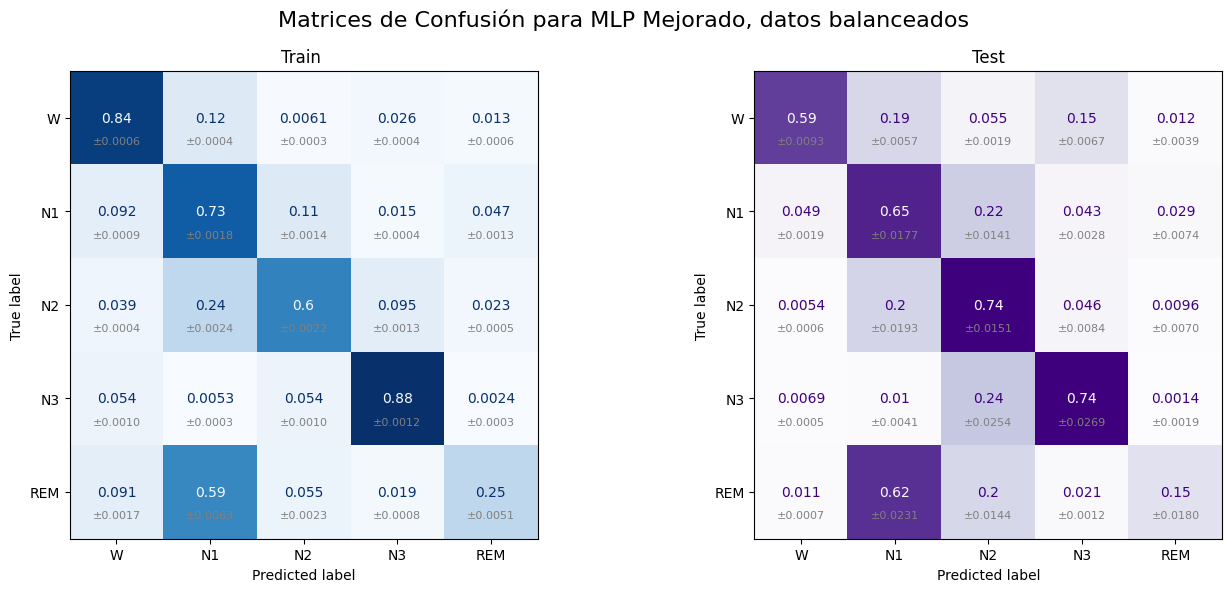

In [ ]:
# @title
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# TRAIN
# Access the list of confusion matrices stored per epoch
train_matrices = np.array([run['train_cm'][-1] for run in curves_history])
train_matrices_norm = np.array([cm / cm.sum(axis=1, keepdims=True) for cm in train_matrices])
train_mean = np.nanmean(train_matrices_norm, axis=0) # Use nanmean to handle potential NaNs from normalization
train_std = np.nanstd(train_matrices_norm, axis=0) # Use nanstd

# TEST
test_matrices = np.array(test_cm_history)
test_mean = test_matrices.mean(axis=0)
test_std = test_matrices.std(axis=0)

# Visualización
class_names = ["W", "N1", "N2", "N3", "REM"]
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Matrices de Confusión para MLP Mejorado, datos balanceados", fontsize=16)

# TRAIN
disp_train = ConfusionMatrixDisplay(train_mean, display_labels=class_names)
disp_train.plot(ax=ax[0], cmap="Blues", colorbar=False)
ax[0].set_title("Train ")
for (i, j), val in np.ndenumerate(train_mean):
    ax[0].text(j, i + 0.25, f"±{train_std[i, j]:.4f}", ha="center", va="center", fontsize=8, color="gray")

# TEST
disp_test = ConfusionMatrixDisplay(test_mean, display_labels=class_names)
disp_test.plot(ax=ax[1], cmap="Purples", colorbar=False)
ax[1].set_title("Test")
for (i, j), val in np.ndenumerate(test_mean):
    ax[1].text(j, i + 0.25, f"±{test_std[i, j]:.4f}", ha="center", va="center", fontsize=8, color="gray")

plt.tight_layout()
plt.show()

In [ ]:
# @title
import numpy as np
import pandas as pd
from IPython.display import display

# Nombres de las clases
class_names = ["W", "N1", "N2", "N3", "REM"]

# Inicializar listas para métricas por clase
precision_list = {name: [] for name in class_names}
recall_list = {name: [] for name in class_names}
f1_list = {name: [] for name in class_names}
accuracy_list = []

# Calcular métricas por iteración usando test_cm_history
for cm in test_cm_history:
    acc = np.trace(cm) / cm.shape[0]
    accuracy_list.append(acc)

    for i, name in enumerate(class_names):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP

        precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

        precision_list[name].append(precision)
        recall_list[name].append(recall)
        f1_list[name].append(f1)

# Crear DataFrame con métricas promedio ± std
data = []
for name in class_names:
    p_mean = np.mean(precision_list[name])
    p_std = np.std(precision_list[name])
    r_mean = np.mean(recall_list[name])
    r_std = np.std(recall_list[name])
    f_mean = np.mean(f1_list[name])
    f_std = np.std(f1_list[name])
    data.append([
        f"{p_mean:.4f} ± {p_std:.4f}",
        f"{r_mean:.4f} ± {r_std:.4f}",
        f"{f_mean:.4f} ± {f_std:.4f}"
    ])

# Agregar accuracy global
acc_mean = np.mean(accuracy_list)
acc_std = np.std(accuracy_list)
data.append([
    f"{acc_mean:.4f} ± {acc_std:.4f}",
    "",
    ""
])

# Crear tabla como DataFrame
df_metrics = pd.DataFrame(data, columns=["Precisión", "Recall", "F1-score"], index=class_names + ["Accuracy Global"])

# Mostrar tabla en notebook
display(df_metrics)

,Precisión,Recall,F1-score
W,0.8899 ± 0.0026,0.5905 ± 0.0093,0.7099 ± 0.0060
N1,0.3896 ± 0.0067,0.6547 ± 0.0177,0.4884 ± 0.0054
N2,0.5056 ± 0.0068,0.7359 ± 0.0151,0.5993 ± 0.0033
N3,0.7379 ± 0.0067,0.7364 ± 0.0269,0.7368 ± 0.0105
REM,0.7481 ± 0.0471,0.1487 ± 0.0180,0.2470 ± 0.0234
Accuracy Global,0.5732 ± 0.0040,,


In [ ]:
# @title
print("##############################################")
print("##### Classification Report (Validation) #####")
print("##############################################")
print()
print(classification_report(y_val, val_predicted_labels, target_names=class_names, digits=4))

##############################################
##### Classification Report (Validation) #####
##############################################

              precision    recall  f1-score   support

           W     0.8904    0.9555    0.9218     57308
          N1     0.1553    0.0062    0.0119      4048
          N2     0.6702    0.8233    0.7389     13481
          N3     0.7725    0.5676    0.6543      3242
         REM     0.4435    0.2329    0.3054      5307

    accuracy                         0.8270     83386
   macro avg     0.5864    0.5171    0.5265     83386
weighted avg     0.7861    0.8270    0.7984     83386



#CNN + LSTM

###Creacion de datasets y balanceo de datos

Creamos df_all

In [ ]:
#se monta archivo de colab
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:

import os
import pandas as pd

# Ruta de los datos procesados
data_path = "/content/drive/MyDrive/sleep-edf-processed/"

# Buscar todos los archivos *_features.csv
feature_files = [f for f in os.listdir(data_path) if f.endswith("_features.csv")]

# Inicializar lista para almacenar los DataFrames
df_list = []

# Cargar y acumular cada archivo
for file in feature_files:
    file_path = os.path.join(data_path, file)
    try:
        df = pd.read_csv(file_path)
        df_list.append(df)
    except Exception as e:
        print(f"Error al cargar {file}: {e}")

# Combinar todos los DataFrames
if df_list:
    df_all = pd.concat(df_list, ignore_index=True)
    print(f"Total de muestras combinadas: {df_all.shape[0]}")

    # Guardar en CSV
    output_path = os.path.join(data_path, "all_subjects_features.csv")
    df_all.to_csv(output_path, index=False)
    print("Archivo guardado en:", output_path)
else:
    print("No se encontraron archivos *_features.csv válidos.")


Total de muestras combinadas: 1303610
Archivo guardado en: /content/drive/MyDrive/sleep-edf-processed/all_subjects_features.csv


Normalizado y balanceo

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset
from IPython.display import display

# --- Cargar datos ---
data_path = "/content/drive/MyDrive/sleep-edf-processed/"
df_all = pd.read_csv(os.path.join(data_path, "all_subjects_features.csv")).dropna()

# --- Columnas de features ---
cols_excluir = ["sujeto", "epoch_index", "stage", "code"]
feature_cols = [c for c in df_all.columns if c not in cols_excluir]

# --- Separación por sujeto ---
unique_subjects = np.unique(df_all["sujeto"])
train_subjects, temp_subjects = train_test_split(unique_subjects, test_size=0.4, random_state=42)
val_subjects, test_subjects = train_test_split(temp_subjects, test_size=0.5, random_state=42)

def sujeto_in_conjunto(df, sujetos_list):
    return df[df["sujeto"].isin(sujetos_list)]

df_train = sujeto_in_conjunto(df_all, train_subjects)
df_val = sujeto_in_conjunto(df_all, val_subjects)
df_test = sujeto_in_conjunto(df_all, test_subjects)

# --- Displays desbalanceados ---
print("# DataFrame desbalanceado (df_train)")
display(df_train.head())
print(df_train["stage"].value_counts())

print("\n# DataFrame desbalanceado (df_val)")
print(df_val["stage"].value_counts())

print("\n# DataFrame de test (df_test)")
print(df_test["stage"].value_counts())

# --- Objetivos ajustados ---
objetivos_train = {
    0: 130000,  # W
    1: 125000,  # N2 (proporcional a 41740/50000 * 130000)
    2: 80000,   # REM
    3: 80000,   # N1
    4: 50000    # N3
}

#objetivos_val = {
#    0: 50000,   # W (≈ 38% de train)
#    1: 48000,   # N2
#    2: 20000,   # REM
#    3: 20000,   # N1
#    4: 12000    # N3
#}


# --- Balanceo general ---
def balanceo_df(df, label_col, objetivos, seed=42):
    np.random.seed(seed)
    dfs = []
    for clase, n_obj in objetivos.items():
        df_clase = df[df[label_col] == clase]
        df_sampled = df_clase.sample(n=n_obj, replace=(len(df_clase) < n_obj), random_state=seed)
        dfs.append(df_sampled)
    return pd.concat(dfs).sample(frac=1, random_state=seed).reset_index(drop=True)

# --- Aplicar balanceo ---
df_train_bal = balanceo_df(df_train, "code", objetivos_train)
#df_val_bal = balanceo_df(df_val, "code", objetivos_val)

# --- Verificar distribución por clase ---
print("\nDistribución train balanceado:")
display(df_train_bal.head())
print(df_train_bal["stage"].value_counts())

#print("\nDistribución val balanceado:")
#print(df_val_bal["stage"].value_counts())

# --- Crear secuencias ---
def crear_secuencias(df, feature_cols, sequence_length=10):
    sequences, labels = [], []
    for sujeto, grupo in df.groupby("sujeto"):
        grupo = grupo.sort_values("epoch_index")
        X = grupo[feature_cols].to_numpy(dtype=np.float32)
        y = grupo["code"].to_numpy(dtype=np.int64)
        for i in range(len(X) - sequence_length + 1):
            sequences.append(X[i:i+sequence_length])
            labels.append(y[i+sequence_length-1])
    return np.array(sequences), np.array(labels)

# Secuencias desbalanceadas
X_train_desb, y_train_desb = crear_secuencias(df_train, feature_cols)
X_val, y_val = crear_secuencias(df_val, feature_cols)

# Secuencias balanceadas
X_train_bal, y_train_bal = crear_secuencias(df_train_bal, feature_cols)
#X_val_bal, y_val_bal = crear_secuencias(df_val_bal, feature_cols)

# --- Normalización ---
scaler = StandardScaler()
#desbalanceados
X_train_desb_scaled = scaler.fit_transform(X_train_desb.reshape(-1, X_train_desb.shape[2])).reshape(X_train_desb.shape)
X_val_desb_scaled = scaler.fit_transform(X_val.reshape(-1, X_val.shape[2])).reshape(X_val.shape)
#balanceado
X_train_bal_scaled = scaler.fit_transform(X_train_bal.reshape(-1, X_train_bal.shape[2])).reshape(X_train_bal.shape)

# Para el entrenamiento
X_train_bal_tensor = torch.tensor(X_train_bal_scaled, dtype=torch.float32)
y_train_bal_tensor = torch.tensor(y_train_bal, dtype=torch.long)

X_val_bal_tensor = torch.tensor(X_val_desb_scaled, dtype=torch.float32)
#y_val_tensor = torch.tensor(y_val, dtype=torch.long)

#ahora X_train_desv_tensor y y_train... tambien
X_train_desb_tensor = torch.tensor(X_train_desb_scaled, dtype=torch.float32)
y_train_desb_tensor = torch.tensor(y_train_desb, dtype=torch.long)

#AHORA PARA VAL
X_val_desb_tensor = torch.tensor(X_val_desb_scaled, dtype=torch.float32)
y_val_desb_tensor = torch.tensor(y_val, dtype=torch.long)

# --- Tensores y Datasets ---
def crear_dataset(X, y):
    return TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long))

train_dataset_desbalanceado = crear_dataset(X_train_desb_scaled, y_train_desb)
val_dataset = crear_dataset(X_val_desb_scaled, y_val)

train_dataset_balanceado = crear_dataset(X_train_bal_scaled, y_train_bal)
#val_dataset_balanceado = crear_dataset(X_val_bal_scaled, y_val_bal)

# DataFrame desbalanceado (df_train)


,sujeto,epoch_index,stage,code,EEG_delta,EEG_theta,EEG_alpha,EEG_sigma,EEG_beta,EEG_mean,EEG_std
2650,SC4002,0,W,0,0.620759,0.067534,0.013880,0.010385,0.036272,2.490193e-07,0.000031
2651,SC4002,1,W,0,0.622300,0.032508,0.009057,0.005327,0.017695,9.313243e-07,0.000043
2652,SC4002,2,W,0,0.643456,0.123804,0.022489,0.008139,0.017262,2.115285e-06,0.000035
2653,SC4002,3,W,0,0.614611,0.053247,0.009927,0.009639,0.028970,-8.789683e-07,0.000049
2654,SC4002,4,W,0,0.689498,0.074490,0.013024,0.009631,0.034269,9.025399e-07,0.000038


stage
W      528523
N2     130542
REM     48588
N1      40923
N3      22983
Name: count, dtype: int64

# DataFrame desbalanceado (df_val)
stage
W      186573
N2      42111
REM     14993
N1      14018
N3       9710
Name: count, dtype: int64

# DataFrame de test (df_test)
stage
W      180086
N2      44341
REM     17824
N1      11379
N3       9504
Name: count, dtype: int64

Distribución train balanceado:


,sujeto,epoch_index,stage,code,EEG_delta,EEG_theta,EEG_alpha,EEG_sigma,EEG_beta,EEG_mean,EEG_std
0,SC4651,1335,N1,1,0.544484,0.157294,0.040687,0.036566,0.073859,2.204526e-06,0.000006
1,SC4071,1137,N2,2,0.703275,0.079008,0.027847,0.029757,0.003965,1.694485e-06,0.000017
2,SC4812,2234,W,0,0.526980,0.091174,0.028455,0.028868,0.095926,8.630273e-07,0.000022
3,SC4481,1284,N3,3,0.689482,0.016476,0.010174,0.003605,0.001344,9.610573e-06,0.000036
4,SC4602,1872,N2,2,0.610711,0.041907,0.023385,0.009576,0.007737,-9.488260e-07,0.000015


stage
W      130000
N1     125000
N2      80000
N3      80000
REM     50000
Name: count, dtype: int64


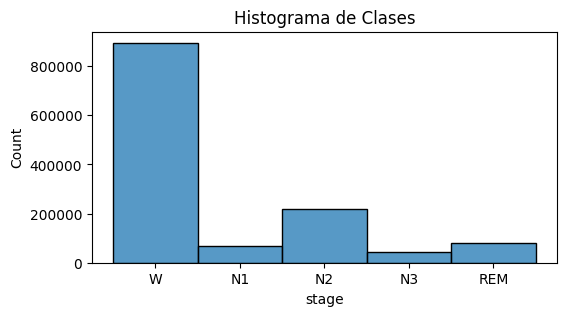

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6,3))
sns.histplot(df_all["stage"])
plt.title("Histograma de Clases")
plt.show()

Train adaptado

In [ ]:
import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix # Import confusion_matrix

# EarlyStopping class
class EarlyStopping:
    def __init__(self, n_epochs_tolerance=5):
        self.patience = n_epochs_tolerance
        self.best_loss = float('inf')
        self.counter = 0
        self.should_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True
        return self.should_stop

# Paso de entrenamiento
def train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu):
    if use_gpu:
        x_batch = x_batch.cuda()
        y_batch = y_batch.cuda()

    # Predicción
    y_predicted = model(x_batch)

    # Cálculo de loss
    loss = criterion(y_predicted, y_batch)

    # Actualización de parámetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return y_predicted, loss

# Función principal de entrenamiento
def train_model(
    model,
    train_dataset,
    val_dataset,
    max_epochs,
    criterion,
    batch_size,
    lr,
    n_evaluations_per_epoch=6,
    early_stopping_tolerance=25,
    use_gpu=False
):
    if use_gpu:
        model.cuda()

    early_stopping = EarlyStopping(n_epochs_tolerance=early_stopping_tolerance)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=use_gpu)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False, pin_memory=use_gpu)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    curves = {
        "train_acc": [],
        "val_acc": [],
        "train_loss": [],
        "val_loss": [],
        "train_cm": []
    }

    t0 = time.perf_counter()
    iteration = 0
    n_batches = len(train_loader)

    for epoch in range(max_epochs):
        cumulative_train_loss = 0
        cumulative_train_corrects = 0
        train_loss_count = 0
        train_acc_count = 0

        epoch_train_preds = []
        epoch_train_labels = []

        model.train()
        for i, (x_batch, y_batch) in enumerate(train_loader):
            print(f"\rEpoch {epoch + 1}/{max_epochs} - Batch {i}/{n_batches} ", end="")

            y_predicted, loss = train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu)

            cumulative_train_loss += loss.item()
            train_loss_count += 1
            train_acc_count += y_batch.shape[0]

            class_prediction = torch.argmax(y_predicted, axis=1).long()
            cumulative_train_corrects += (y_batch == class_prediction).sum().item()

            epoch_train_preds.append(class_prediction.cpu().numpy())
            epoch_train_labels.append(y_batch.cpu().numpy())

            if (i % (n_batches // n_evaluations_per_epoch) == 0) and (i > 0):
                train_loss = cumulative_train_loss / train_loss_count
                train_acc = cumulative_train_corrects / train_acc_count
                print(f"Iteration {iteration} - Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}")

            iteration += 1

        epoch_train_preds = np.concatenate(epoch_train_preds)
        epoch_train_labels = np.concatenate(epoch_train_labels)
        train_cm = confusion_matrix(epoch_train_labels, epoch_train_preds, labels=np.arange(5))
        curves["train_cm"].append(train_cm)

        # Validación
        model.eval()
        x_val, y_val = next(iter(val_loader))
        if use_gpu:
            x_val = x_val.cuda()
            y_val = y_val.cuda()

        with torch.no_grad():
            y_predicted = model(x_val)
            loss = criterion(y_predicted, y_val)

        class_prediction = torch.argmax(y_predicted, axis=1)
        val_acc = (y_val == class_prediction).float().mean()
        val_loss = loss.item()

        train_loss = cumulative_train_loss / train_loss_count
        train_acc = cumulative_train_corrects / train_acc_count

        curves["train_acc"].append(train_acc)
        curves["val_acc"].append(val_acc.item())
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)

        print(f" - Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}, Val loss: {val_loss:.4f}, Val acc: {val_acc:.4f}")

        if early_stopping(val_loss):
            print("Early stopping.")
            break

    print(f"\nTiempo total de entrenamiento: {time.perf_counter() - t0:.2f} [s]")
    model.cpu()
    return curves

#######################
##### Performance #####
#######################
def performance_metrics(TP, FP, FN, TN):
    """Calcula metricas de desempeño.

    Args:
        TP: Numero de verdaderos positivos.
        FP: Numero de falsos positivos.
        FN: Numero de falsos negativos.
        TN: Numero de verdaderos negativos.

    Returns:
        accuracy: Porcentaje de clasificaciones correctas del detector.
        precision: Precision del detector.
        recall: Recall/Sensibilidad del detector.
    """
    accuracy = 100.0 * (TP + TN) / (TP + TN + FP + FN)
    precision = 100.0 * TP / (TP + FP)
    recall = 100.0 * TP / (TP + FN)
    print(f"TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")
    print(f"{accuracy:.4f} Accuracy (Porcentaje de clasificaciones correctas)")
    print(f"{precision:.4f} Precision")
    print(f"{recall:.4f} Recall")
    print()
    return accuracy, precision, recall

def roc_curve(labels, probabilities):
    """Calcula la curva ROC.

    Args:
        labels: Array binario 1-D con las etiquetas reales.
        probabilities: Array 1-D continuo en el rango [0, 1] con las
            probabilidades de la clase 1.

    Returns:
        tpr: Array 1-D con los valores de Tasa de Verdaderos Positivos (TPR).
        fpr: Array 1-D con los valores de Tasa de Falsos Positivos (FPR).
    """
    tpr = []
    fpr = []
    for threshold in np.linspace(0, 1, 1000):
        TN, FP, FN, TP = conf_matrix_given_threshold(labels, probabilities, threshold)
        tpr.append(TP / (TP + FN))
        fpr.append(FP / (FP + TN))

    return np.array(tpr), np.array(fpr)

def conf_matrix_given_threshold(true_labels, prediction, threshold):
    probabilities_with_threshold = (prediction > threshold).long()
    TN, FP, FN, TP = confusion_matrix(true_labels, probabilities_with_threshold).ravel()
    return TN, FP, FN, TP

Modelo

Se transformó el DataFrame en secuencias de 10 épocas consecutivas por sujeto, ordenadas temporalmente. Cada secuencia se representa como un tensor y se le asigna la etiqueta de la última época, permitiendo entrenar modelos que capturan patrones temporales como CNN + LSTM.

In [ ]:
import torch
import torch.nn as nn

class CNN_LSTM_Model(nn.Module):
    def __init__(self, input_size=7, hidden_size=64, num_layers=1, dropout_p=0.3, num_classes=5):
        super(CNN_LSTM_Model, self).__init__()

        # CNN para extraer características por época
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
        )

        # LSTM para modelar la secuencia de épocas
        self.lstm = nn.LSTM(input_size=32, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

        # Clasificador final
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_p),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, x):
        # x: [batch_size, seq_len, feature_dim]
        batch_size, seq_len, feature_dim = x.size()

        # Aplicar CNN a cada época
        x = x.view(batch_size * seq_len, 1, feature_dim)  # [batch_size*seq_len, 1, feature_dim]
        x = self.cnn(x)  # [batch_size*seq_len, 32, reduced_dim]
        x = x.view(batch_size, seq_len, -1)  # [batch_size, seq_len, 32]

        # LSTM
        lstm_out, _ = self.lstm(x)  # [batch_size, seq_len, hidden_size]
        final_output = lstm_out[:, -1, :]  # Tomamos la última salida

        # Clasificación
        out = self.classifier(final_output)
        return out

##CNN + LSTM Balanceado

In [ ]:
# Parámetros de entrenamiento
lr_cnn_bal = 5e-4
dropout_p_cnn_bal = 0.35
batch_size_cnn_bal = 256
epochs_cnn_bal = 30
use_gpu_cnn_bal = False

# Inicialización
curves_history_cnn_bal = []
test_acc_history_cnn_bal = []
test_cm_history_cnn_bal = []

for i in range(5):
    print(f"Iteración CNN-LSTM Balanceado N° {i+1}")

    model_cnn_bal = CNN_LSTM_Model(
        input_size=X_train_bal_tensor.shape[2],
        dropout_p=dropout_p_cnn_bal,
        num_classes=5
    )

    curves_cnn_bal = train_model(
        model=model_cnn_bal,
        train_dataset=train_dataset_balanceado,
        val_dataset=val_dataset,
        max_epochs=epochs_cnn_bal,
        criterion=nn.CrossEntropyLoss(),
        batch_size=batch_size_cnn_bal,
        lr=lr_cnn_bal,
        n_evaluations_per_epoch=5,
        early_stopping_tolerance=25,
        use_gpu=use_gpu_cnn_bal
    )

    model_cnn_bal.eval()
    with torch.no_grad():
        y_val_pred_cnn_bal = model_cnn_bal(X_val_bal_tensor)
        val_pred_labels_cnn_bal = torch.argmax(y_val_pred_cnn_bal, axis=1)
        val_acc_cnn_bal = (val_pred_labels_cnn_bal == y_val_desb_tensor).float().mean().item()
        test_acc_history_cnn_bal.append(val_acc_cnn_bal)

        cm_val_cnn_bal = confusion_matrix(
            y_val_desb_tensor.numpy(),
            val_pred_labels_cnn_bal.numpy(),
            labels=np.arange(5),
            normalize='true'
        )
        test_cm_history_cnn_bal.append(cm_val_cnn_bal)

    print()
    curves_history_cnn_bal.append(curves_cnn_bal)

# Estadísticas finales
test_acc_history_cnn_bal = np.array(test_acc_history_cnn_bal)
test_acc_mean_cnn_bal = test_acc_history_cnn_bal.mean()
test_acc_std_cnn_bal = test_acc_history_cnn_bal.std()

print(f"Accuracy final CNN-LSTM (balanceado): {test_acc_mean_cnn_bal:.4f} ± {test_acc_std_cnn_bal:.4f}")

Iteración CNN-LSTM Balanceado N° 1
Epoch 1/30 - Batch 362/1814 Iteration 362 - Train loss: 1.0409, Train acc: 0.5739
Epoch 1/30 - Batch 724/1814 Iteration 724 - Train loss: 0.9012, Train acc: 0.6370
Epoch 1/30 - Batch 1086/1814 Iteration 1086 - Train loss: 0.8386, Train acc: 0.6641
Epoch 1/30 - Batch 1448/1814 Iteration 1448 - Train loss: 0.8002, Train acc: 0.6800
Epoch 1/30 - Batch 1810/1814 Iteration 1810 - Train loss: 0.7729, Train acc: 0.6912
Epoch 1/30 - Batch 1813/1814  - Train loss: 0.7727, Train acc: 0.6912, Val loss: 1.5515, Val acc: 0.5175
Epoch 2/30 - Batch 362/1814 Iteration 2176 - Train loss: 0.6465, Train acc: 0.7420
Epoch 2/30 - Batch 724/1814 Iteration 2538 - Train loss: 0.6397, Train acc: 0.7452
Epoch 2/30 - Batch 1086/1814 Iteration 2900 - Train loss: 0.6329, Train acc: 0.7485
Epoch 2/30 - Batch 1448/1814 Iteration 3262 - Train loss: 0.6254, Train acc: 0.7518
Epoch 2/30 - Batch 1810/1814 Iteration 3624 - Train loss: 0.6186, Train acc: 0.7550
Epoch 2/30 - Batch 1813/18

###Metricas de desempeño

In [ ]:
# @title
# Accuracy en entrenamiento
train_acc_history_cnn_bal = np.array([run['train_acc'][-1] for run in curves_history_cnn_bal])
train_acc_mean_cnn_bal = train_acc_history_cnn_bal.mean()
train_acc_std_cnn_bal = train_acc_history_cnn_bal.std()
print('Accuracy final en entrenamiento: %.4f ± %.4f' % (train_acc_mean_cnn_bal, train_acc_std_cnn_bal))

# Accuracy en validación
val_acc_history_cnn_bal = np.array([run['val_acc'][-1] for run in curves_history_cnn_bal])
val_acc_mean_cnn_bal = val_acc_history_cnn_bal.mean()
val_acc_std_cnn_bal = val_acc_history_cnn_bal.std()
print('Accuracy final en validación: %.4f ± %.4f' % (val_acc_mean_cnn_bal, val_acc_std_cnn_bal))

# Accuracy en test
test_acc_mean_cnn_bal = test_acc_history_cnn_bal.mean()
test_acc_std_cnn_bal = test_acc_history_cnn_bal.std()
print('Accuracy final en test: %.4f ± %.4f' % (test_acc_mean_cnn_bal, test_acc_std_cnn_bal))

Accuracy final en entrenamiento: 0.8926 ± 0.0010
Accuracy final en validación: 0.5018 ± 0.0197
Accuracy final en test: 0.5018 ± 0.0197


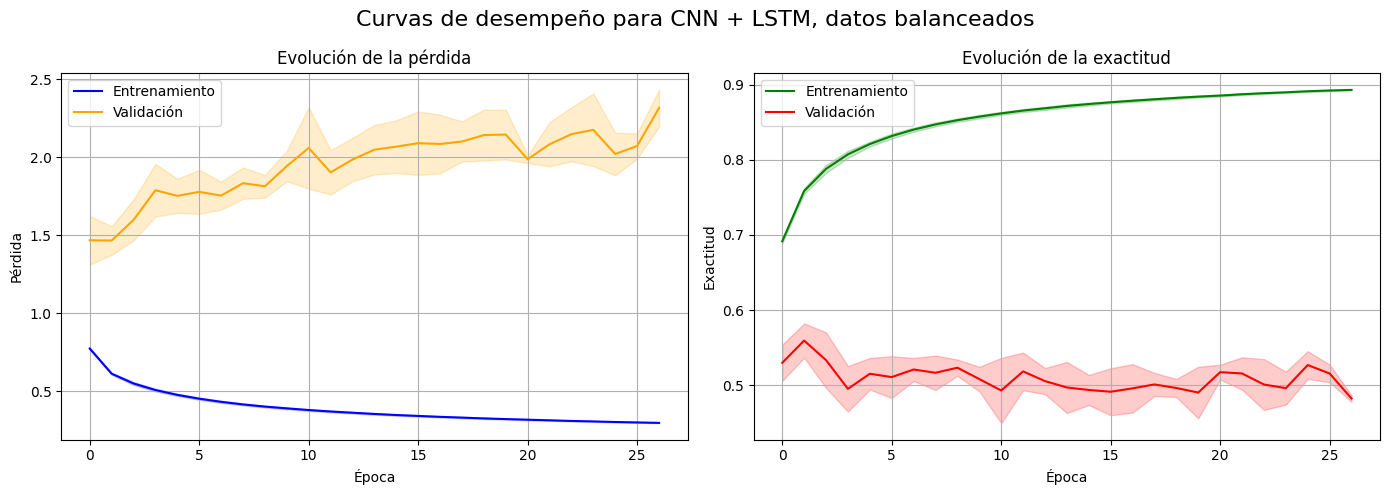

In [ ]:
# @title

# Curvas de entrenamiento CNN + LSTM (balanceado)
import numpy as np
import matplotlib.pyplot as plt

max_epochs_cnn_bal = max(len(run['train_loss']) for run in curves_history_cnn_bal)

def pad_with_nan(runs, max_len):
    return [run + [np.nan] * (max_len - len(run)) for run in runs]

train_loss_all_cnn_bal = np.array(pad_with_nan([run['train_loss'] for run in curves_history_cnn_bal], max_epochs_cnn_bal))
val_loss_all_cnn_bal = np.array(pad_with_nan([run['val_loss'] for run in curves_history_cnn_bal], max_epochs_cnn_bal))
train_acc_all_cnn_bal = np.array(pad_with_nan([run['train_acc'] for run in curves_history_cnn_bal], max_epochs_cnn_bal))
val_acc_all_cnn_bal = np.array(pad_with_nan([run['val_acc'] for run in curves_history_cnn_bal], max_epochs_cnn_bal))

train_loss_mean_cnn_bal = np.nanmean(train_loss_all_cnn_bal, axis=0)
train_loss_std_cnn_bal = np.nanstd(train_loss_all_cnn_bal, axis=0)
val_loss_mean_cnn_bal = np.nanmean(val_loss_all_cnn_bal, axis=0)
val_loss_std_cnn_bal = np.nanstd(val_loss_all_cnn_bal, axis=0)

train_acc_mean_cnn_bal = np.nanmean(train_acc_all_cnn_bal, axis=0)
train_acc_std_cnn_bal = np.nanstd(train_acc_all_cnn_bal, axis=0)
val_acc_mean_cnn_bal = np.nanmean(val_acc_all_cnn_bal, axis=0)
val_acc_std_cnn_bal = np.nanstd(val_acc_all_cnn_bal, axis=0)

epochs_cnn_bal = np.arange(0, max_epochs_cnn_bal)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
fig.set_facecolor('white')
fig.suptitle("Curvas de desempeño para CNN + LSTM, datos balanceados", fontsize=16)

# Loss
ax[0].plot(epochs_cnn_bal, train_loss_mean_cnn_bal, label='Entrenamiento', color='blue')
ax[0].fill_between(epochs_cnn_bal, train_loss_mean_cnn_bal - train_loss_std_cnn_bal, train_loss_mean_cnn_bal + train_loss_std_cnn_bal, color='blue', alpha=0.2)
ax[0].plot(epochs_cnn_bal, val_loss_mean_cnn_bal, label='Validación', color='orange')
ax[0].fill_between(epochs_cnn_bal, val_loss_mean_cnn_bal - val_loss_std_cnn_bal, val_loss_mean_cnn_bal + val_loss_std_cnn_bal, color='orange', alpha=0.2)
ax[0].set_xlabel('Época')
ax[0].set_ylabel('Pérdida')
ax[0].set_title('Evolución de la pérdida')
ax[0].legend()
ax[0].grid(True)

# Accuracy
ax[1].plot(epochs_cnn_bal, train_acc_mean_cnn_bal, label='Entrenamiento', color='green')
ax[1].fill_between(epochs_cnn_bal, train_acc_mean_cnn_bal - train_acc_std_cnn_bal, train_acc_mean_cnn_bal + train_acc_std_cnn_bal, color='green', alpha=0.2)
ax[1].plot(epochs_cnn_bal, val_acc_mean_cnn_bal, label='Validación', color='red')
ax[1].fill_between(epochs_cnn_bal, val_acc_mean_cnn_bal - val_acc_std_cnn_bal, val_acc_mean_cnn_bal + val_acc_std_cnn_bal, color='red', alpha=0.2)
ax[1].set_xlabel('Época')
ax[1].set_ylabel('Exactitud')
ax[1].set_title('Evolución de la exactitud')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

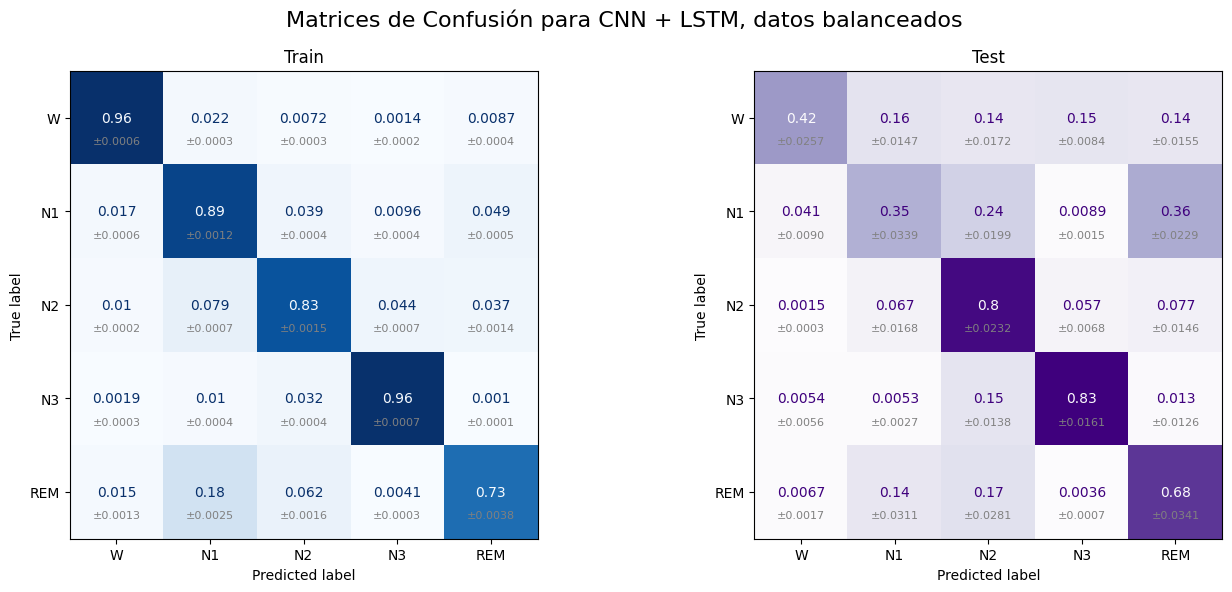

In [ ]:
# @title

# Matrices de confusión CNN + LSTM (balanceado)
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

train_matrices_cnn_bal = np.array([run['train_cm'][-1] for run in curves_history_cnn_bal])
train_matrices_norm_cnn_bal = np.array([cm / cm.sum(axis=1, keepdims=True) for cm in train_matrices_cnn_bal])
train_mean_cnn_bal = np.nanmean(train_matrices_norm_cnn_bal, axis=0)
train_std_cnn_bal = np.nanstd(train_matrices_norm_cnn_bal, axis=0)

test_matrices_cnn_bal = np.array(test_cm_history_cnn_bal)
test_mean_cnn_bal = test_matrices_cnn_bal.mean(axis=0)
test_std_cnn_bal = test_matrices_cnn_bal.std(axis=0)

class_names = ["W", "N1", "N2", "N3", "REM"]
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Matrices de Confusión para CNN + LSTM, datos balanceados", fontsize=16)

# TRAIN
disp_train = ConfusionMatrixDisplay(train_mean_cnn_bal, display_labels=class_names)
disp_train.plot(ax=ax[0], cmap="Blues", colorbar=False)
ax[0].set_title("Train")
for (i, j), val in np.ndenumerate(train_mean_cnn_bal):
    ax[0].text(j, i + 0.25, f"±{train_std_cnn_bal[i, j]:.4f}", ha="center", va="center", fontsize=8, color="gray")

# TEST
disp_test = ConfusionMatrixDisplay(test_mean_cnn_bal, display_labels=class_names)
disp_test.plot(ax=ax[1], cmap="Purples", colorbar=False)
ax[1].set_title("Test")
for (i, j), val in np.ndenumerate(test_mean_cnn_bal):
    ax[1].text(j, i + 0.25, f"±{test_std_cnn_bal[i, j]:.4f}", ha="center", va="center", fontsize=8, color="gray")

plt.tight_layout()
plt.show()

In [ ]:
# @title

# Métricas por clase CNN + LSTM (balanceado)
import pandas as pd

precision_list_cnn_bal = {name: [] for name in class_names}
recall_list_cnn_bal = {name: [] for name in class_names}
f1_list_cnn_bal = {name: [] for name in class_names}
accuracy_list_cnn_bal = []

for cm in test_cm_history_cnn_bal:
    acc = np.trace(cm) / cm.shape[0]
    accuracy_list_cnn_bal.append(acc)

    for i, name in enumerate(class_names):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP

        precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

        precision_list_cnn_bal[name].append(precision)
        recall_list_cnn_bal[name].append(recall)
        f1_list_cnn_bal[name].append(f1)

# Crear DataFrame con métricas promedio ± std
data_cnn_bal = []
for name in class_names:
    p_mean = np.mean(precision_list_cnn_bal[name])
    p_std = np.std(precision_list_cnn_bal[name])
    r_mean = np.mean(recall_list_cnn_bal[name])
    r_std = np.std(recall_list_cnn_bal[name])
    f_mean = np.mean(f1_list_cnn_bal[name])
    f_std = np.std(f1_list_cnn_bal[name])
    data_cnn_bal.append([
        f"{p_mean:.4f} ± {p_std:.4f}",
        f"{r_mean:.4f} ± {r_std:.4f}",
        f"{f_mean:.4f} ± {f_std:.4f}"
    ])

# Agregar accuracy global
acc_mean = np.mean(accuracy_list_cnn_bal)
acc_std = np.std(accuracy_list_cnn_bal)
data_cnn_bal.append([
    f"{acc_mean:.4f} ± {acc_std:.4f}",
    "",
    ""
])

df_metrics_cnn_bal = pd.DataFrame(data_cnn_bal, columns=["Precisión", "Recall", "F1-score"], index=class_names + ["Accuracy Global"])
display(df_metrics_cnn_bal)

,Precisión,Recall,F1-score
W,0.8842 ± 0.0188,0.4151 ± 0.0257,0.5643 ± 0.0219
N1,0.4882 ± 0.0165,0.3490 ± 0.0339,0.4055 ± 0.0188
N2,0.5353 ± 0.0191,0.7971 ± 0.0232,0.6400 ± 0.0119
N3,0.7910 ± 0.0082,0.8259 ± 0.0161,0.8080 ± 0.0083
REM,0.5354 ± 0.0105,0.6829 ± 0.0341,0.5997 ± 0.0115
Accuracy Global,0.6140 ± 0.0089,,


In [ ]:
# @title

# Métricas por clase CNN + LSTM (balanceado)
import pandas as pd

precision_list_cnn_bal = {name: [] for name in class_names}
recall_list_cnn_bal = {name: [] for name in class_names}
f1_list_cnn_bal = {name: [] for name in class_names}
accuracy_list_cnn_bal = []

for cm in test_cm_history_cnn_bal:
    acc = np.trace(cm) / cm.shape[0]
    accuracy_list_cnn_bal.append(acc)

    for i, name in enumerate(class_names):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP

        precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

        precision_list_cnn_bal[name].append(precision)
        recall_list_cnn_bal[name].append(recall)
        f1_list_cnn_bal[name].append(f1)

# Crear DataFrame con métricas promedio ± std
data_cnn_bal = []
for name in class_names:
    p_mean = np.mean(precision_list_cnn_bal[name])
    p_std = np.std(precision_list_cnn_bal[name])
    r_mean = np.mean(recall_list_cnn_bal[name])
    r_std = np.std(recall_list_cnn_bal[name])
    f_mean = np.mean(f1_list_cnn_bal[name])
    f_std = np.std(f1_list_cnn_bal[name])
    data_cnn_bal.append([
        f"{p_mean:.4f} ± {p_std:.4f}",
        f"{r_mean:.4f} ± {r_std:.4f}",
        f"{f_mean:.4f} ± {f_std:.4f}"
    ])

# Agregar accuracy global
acc_mean = np.mean(accuracy_list_cnn_bal)
acc_std = np.std(accuracy_list_cnn_bal)
data_cnn_bal.append([
    f"{acc_mean:.4f} ± {acc_std:.4f}",
    "",
    ""
])

df_metrics_cnn_bal = pd.DataFrame(data_cnn_bal, columns=["Precisión", "Recall", "F1-score"], index=class_names + ["Accuracy Global"])
display(df_metrics_cnn_bal)

,Precisión,Recall,F1-score
W,0.8842 ± 0.0188,0.4151 ± 0.0257,0.5643 ± 0.0219
N1,0.4882 ± 0.0165,0.3490 ± 0.0339,0.4055 ± 0.0188
N2,0.5353 ± 0.0191,0.7971 ± 0.0232,0.6400 ± 0.0119
N3,0.7910 ± 0.0082,0.8259 ± 0.0161,0.8080 ± 0.0083
REM,0.5354 ± 0.0105,0.6829 ± 0.0341,0.5997 ± 0.0115
Accuracy Global,0.6140 ± 0.0089,,


# Referencias

*   https://iopscience.iop.org/article/10.1088/1742-6596/1028/1/012212/pdf (Mas imitable segun yo)
*   https://mne.tools/stable/auto_tutorials/clinical/60_sleep.html#sphx-glr-auto-tutorials-clinical-60-sleep-py
*   https://pmc.ncbi.nlm.nih.gov/articles/PMC9597665/
*   https://www.researchgate.net/publication/372286369_Classification_of_sleep_stages_from_EEG_EOG_and_EMG_signals_by_SSNet
*   Elemento de la lista
*   Elemento de la lista